This code analyzes Slide-TCR-Seq data.

# Set up environment and functions

In [4]:
# %load_ext nb_black

<IPython.core.display.Javascript object>

In [1]:
# Set up environment and functions
import ast
import bisect
from collections import Counter
import copy
import csv
from datetime import datetime
import math
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib_venn import venn2, venn2_circles
import matplotlib.font_manager as fm
from matplotlib_scalebar.scalebar import ScaleBar
import numpy as np
from os import path
import pandas as pd
import pickle5 as pkl
import scipy.sparse
import scipy
from scipy.spatial import distance
from scipy.stats import kstest, pearsonr, gaussian_kde as kde
from scipy.ndimage import gaussian_filter
import seaborn as sns
from sklearn.decomposition import NMF
from sklearn.neighbors import KNeighborsClassifier
import statsmodels
from statistics import mean, stdev
from statsmodels import stats
import statsmodels.stats.multitest
import sys
from tqdm.notebook import tqdm
from scipy.stats import ttest_ind

plt.rcParams["pdf.fonttype"] = 42


def cohens_d(i, j):
    """Calculates the Cohen's d effect size between two groups"""
    return (mean(i) - mean(j)) / (math.sqrt((stdev(i) ** 2 + stdev(j) ** 2) / 2))


def abline(slope, intercept, ax_name=None):
    """Plot a line from slope and intercept"""
    if ax_name is None:
        axes = plt.gca()
        x_vals = np.array(axes.get_xlim())
        y_vals = intercept + slope * x_vals
        plt.plot(x_vals, y_vals, "--")
    else:
        x_vals = np.array(ax_name.get_xlim())
        y_vals = intercept + slope * x_vals
        ax_name.plot(x_vals, y_vals, "--")


def closest_node(node, nodes):
    """Finds the closest point in a list of points to a given point"""
    closest_index = distance.cdist([node], nodes).argmin()
    return nodes[closest_index]


def distance_between_points(pt1, pt2):
    """Distance between two points"""
    return math.sqrt((pt1[0] - pt2[0]) ** 2 + (pt1[1] - pt2[1]) ** 2)


def switch_dict(orig_dict):
    """Switches the keys and values of a dictionary and merges to a list"""
    new_dict = {}
    for i in orig_dict:
        if orig_dict[i] in new_dict:
            new_dict[orig_dict[i]].append(i)
        else:
            new_dict[orig_dict[i]] = [i]
    return new_dict


def generate_barcode_loc_dictionary(barcode_file, locations_file, old_status=False):
    """Creates barcode and location dictionary from Slide-seq data"""
    barcode_loc_dict = {}

    if old_status:
        with open(barcode_file, "r") as file1, open(locations_file, "r") as file2:
            for line1, line2 in zip(file1, file2):
                line1 = line1.rstrip("\n")
                line2 = line2.rstrip("\n")
                line2_split = list(line2.split("\t"))
                barcode_loc_dict[line1] = (line2_split[1], line2_split[2])

    else:
        barcodes = []
        with open(barcode_file, "r") as file1, open(locations_file, "r") as file2:
            for line in file1:
                line = line.rstrip("\n")
                line = line.replace(",", "")
                barcodes.append(line)

        with open(locations_file, "r") as file1:
            locations = []
            for line in file1:
                line = line.rstrip("\n")
                line_split = list(line.split("\t"))
                locations.append((line_split[1], line_split[2]))

    file1.close()
    file2.close()

    for i, j in enumerate(barcodes):
        barcode_loc_dict[j] = (float(locations[i][0]), float(locations[i][1]))

    return barcode_loc_dict


def hamming_distance(x, y):
    """Reports if hamming distance between two strings is 1"""
    sum_ct = 0
    for i, j in zip(x, y):
        if i != j:
            sum_ct += 1
        if sum_ct > 1:
            return "Fail"

    if sum_ct == 1:
        return 1


def clonotype_to_spatial(
    clonotype_to_barcode,
    barcode_to_spatial,
    display_missed_barcodes=True,
    hamming_correction=True,
    verbose=False,
):
    """Returns dictionary of clonotypes to all spatial locations"""
    cl_to_spatial = {}
    # For each clonotype
    print(len(clonotype_to_barcode), "total to analyze")

    errors = []
    for tcr_clonotype in tqdm(clonotype_to_barcode):
        missed_barcodes = []
        bc_umis_per_cl = clonotype_to_barcode[tcr_clonotype]

        if tcr_clonotype not in cl_to_spatial:
            cl_to_spatial[tcr_clonotype] = []

        all_barcodes = list(set(barcode_to_spatial))
        all_barcodes_firsthalf = {}
        all_barcodes_secondhalf = {}
        for bc in all_barcodes:
            if bc[0:7] not in all_barcodes_firsthalf:
                all_barcodes_firsthalf[bc[0:7]] = []
            all_barcodes_firsthalf[bc[0:7]].append(bc)
            if bc[7:] not in all_barcodes_secondhalf:
                all_barcodes_secondhalf[bc[7:]] = []
            all_barcodes_secondhalf[bc[7:]].append(bc)

        for read in bc_umis_per_cl:
            bc = read[0][0:14]
            if bc in barcode_to_spatial:
                cl_to_spatial[tcr_clonotype].append(barcode_to_spatial[bc])
                continue
            else:
                if display_missed_barcodes:
                    if bc not in missed_barcodes:
                        print(bc, " was not found in in situ barcode sequencing")
                        missed_barcodes.append(bc)

                if hamming_correction:
                    all_barcodes_searchspace = []
                    if bc[7:] in all_barcodes_secondhalf:
                        all_barcodes_searchspace = (
                            all_barcodes_searchspace + all_barcodes_secondhalf[bc[7:]]
                        )
                    if bc[0:7] in all_barcodes_firsthalf:
                        all_barcodes_searchspace = (
                            all_barcodes_searchspace + all_barcodes_firsthalf[bc[0:7]]
                        )
                    all_barcodes_pass_hamming = [
                        bc2
                        for bc2 in all_barcodes_searchspace
                        if hamming_distance(bc, bc2) == 1
                    ]

                    if len(all_barcodes_pass_hamming) > 1:
                        if verbose:
                            print("bc:", bc, "match?", all_barcodes_pass_hamming)
                            print("error not 1 d apart")
                        errors.append(all_barcodes_pass_hamming)
                        continue
                    if len(all_barcodes_pass_hamming) == 1:
                        cl_to_spatial[tcr_clonotype].append(
                            barcode_to_spatial[all_barcodes_pass_hamming[0]]
                        )

                continue

    return cl_to_spatial, errors


def cl_loc_convert_loc_cl(tcr_loc_dict):
    """Converts clonotype-location dictionary to location-clonotype"""
    loc_to_tcr = {}  # Dictionary of locations to clonotypes
    for tcr in tcr_loc_dict:
        loc_all = tcr_loc_dict[tcr]
        for loc in loc_all:
            if loc in loc_to_tcr:
                loc_to_tcr[loc].append(tcr)
            else:
                loc_to_tcr[loc] = [tcr]

    # Remove duplicates
    loc_to_tcr_dedup = {}
    for loc in loc_to_tcr:
        loc_to_tcr_dedup[loc] = set(loc_to_tcr[loc])

    return loc_to_tcr_dedup


def bc_loc_convert_loc_bc(bc_loc_dict):
    """Converts bc-location dictionary to location-bc"""
    loc_bc_dict = {}
    for bc in bc_loc_dict:
        loc_all = bc_loc_dict[bc]

        if loc_all not in loc_bc_dict:
            loc_bc_dict[loc_all] = []

        loc_bc_dict[loc_all].append(bc)

    return loc_bc_dict


def check_clonotype(cl_string, a_clonotypes_list, b_clonotypes_list):
    """Checks if a clonotype is in alpha or beta list"""
    if cl_string in a_clonotypes_list:
        return "a"
    if cl_string in b_clonotypes_list:
        return "b"


def save_to_csv(
    filename, tcr_loc_dict, clonotypes, bc_umi_dict, output_dataframe=True, save=True
):
    """Output a csv file with bead barcodes, locations, and clonotypes
    of tcr_a and tcr_b"""
    loc_to_tcr = cl_loc_convert_loc_cl(
        tcr_loc_dict
    )  # Convert tcr:locations to locations:tcr

    # Make list of all locations
    locations = loc_to_tcr.keys()
    loclist = list(locations)

    # Make list of all clonotypes at each location
    clonotypes_all = []

    for loc in loclist:
        clonotypes_all.append(loc_to_tcr[loc])

    # Separate list of all clonotypes into tcr_a and tcr_b
    clonotypes_a = []
    clonotypes_b = []
    for i in clonotypes_all:
        insert_a = []
        insert_b = []
        for j in i:
            outcome = check_clonotype(j, clonotypes["1a"], clonotypes["1b"])
            if outcome == "a":
                insert_a.append(j)
                insert_b.append("")
            elif outcome == "b":
                insert_b.append(j)
                insert_a.append("")

        clonotypes_a.append(insert_a)
        clonotypes_b.append(insert_b)

    # Make list of bead_barcodes at each location
    bead_barcodes = []
    for i in loclist:
        loc_bc = bc_loc_convert_loc_bc(bc_umi_dict)
        bead_barcodes.append(loc_bc[i])

    # Save as csv
    if save:
        with open(filename, "w") as csvfile:
            fieldnames = ["x", "y", "tcr_a", "tcr_b", "bead_barcodes"]

            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            for i, j in enumerate(loclist):
                writer.writerow(
                    {
                        "x": j[0],
                        "y": j[1],
                        "tcr_a": clonotypes_a[i],
                        "tcr_b": clonotypes_b[i],
                        "bead_barcodes": bead_barcodes[i][0],
                    }
                )

    # Output result as dataframe
    if output_dataframe:
        d = {
            "x": [i[0] for i in loclist],
            "y": [i[1] for i in loclist],
            "tcr_a": clonotypes_a,
            "tcr_b": clonotypes_b,
            "bead_barcodes": [i[0] for i in bead_barcodes],
        }

        df = pd.DataFrame(data=d)
        return df


def import_dge(dge_fn, skip_lines=0, print_progress=True):
    """Imports a dge as a dictionary and barcodes"""
    csv.field_size_limit(sys.maxsize)
    line_count = 0
    new_dict = {}
    with open(dge_fn) as csvfile:

        skip_count = 0
        while skip_count != skip_lines:
            next(csvfile)
            skip_count += 1

        data = csv.DictReader(csvfile, delimiter="\t")

        for row in data:
            line_count += 1
            new_dict[list(row.values())[0]] = [
                float(val) for val in list(row.values())[1:]
            ]

            if line_count % 1000 == 0 and print_progress:
                print(line_count)
                print(datetime.now())

        barcodes = list(row.keys())[1:]

    return new_dict, barcodes


def dge_formatting(dge, barcodes_fn, locations_fn):
    """Formats a dge as a dataframe and returns coordinates for locations"""
    coords_barcodes = pd.read_csv(barcodes_fn, sep="\t", header=None)
    coords_barcodes = [
        i.replace(",", "") for i in list(coords_barcodes[0])
    ]  # Remove commas
    coords_locations = pd.read_csv(locations_fn, sep="\t", header=None)
    coords = pd.DataFrame(coords_locations)
    coords.set_axis(["id", "xcoord", "ycoord"], axis=1, inplace=True)
    coords["barcodes"] = coords_barcodes
    coords.set_index("barcodes", inplace=True)

    barcodes_in_dge = dge.index
    barcodes_in_coords = coords.index
    common_barcodes = [i for i in barcodes_in_dge if i in barcodes_in_coords]
    dge = dge.loc[common_barcodes]
    coords = coords.loc[common_barcodes]

    return dge, coords


def find_specific_barcodes(which_tcr, df_scb):
    """Finds the barcodes of a certain clonotype"""

    tcr_spec = df_scb[which_tcr]

    tcr_spec_counter = []
    ct = 0
    for i in tcr_spec:

        if isinstance(i, list):
            cl = i
        else:
            cl = ast.literal_eval(i)
        cl = [n.strip() for n in cl]
        filt_cl = [j for j in cl if j != ""]
        if len(filt_cl) == 0:
            tcr_spec_counter.append(-1)
        else:
            tcr_spec_counter.append(ct)
        ct += 1

    tcr_specific_barcodes = [
        df_scb["bead_barcodes"][b] for b in tcr_spec_counter if b != -1
    ]

    print(len(tcr_specific_barcodes))
    return tcr_specific_barcodes


def open_sparse_matrix(filename, sample_abbrev):
    """Opens a previously saved sparse matrix as a dataframe, used for DGE"""
    sparse_matrix = scipy.sparse.load_npz(filename)
    sparse_matrix_dense = sparse_matrix.todense()
    sparse_matrix_dense = sparse_matrix_dense.astype(float)
    rows_cols = pd.read_csv("{}_genenames_barcodes.csv".format(sample_abbrev))
    cols = list(rows_cols["Genes"])
    cols = [ast.literal_eval(i) for i in cols][0]
    rows = list(rows_cols["Barcodes"])
    rows = [ast.literal_eval(i) for i in rows][0]
    new_df = pd.DataFrame(data=sparse_matrix_dense, columns=cols, index=rows)
    return new_df


def save_as_sparse(filename, abbrev_sample_reference, skip_lines=0):
    """Saves a dataframe as a sparse matrix, used for DGE"""
    new_dict, barcodes = import_dge(filename, skip_lines, print_progress=True)
    df_dge = pd.DataFrame(data=new_dict, index=barcodes)
    df_dge.index.name = "barcodes"
    dge_fmtd = df_dge
    cols = [list(dge_fmtd.columns)]
    rows = [list(dge_fmtd.index)]
    f = pd.DataFrame({"Genes": cols, "Barcodes": rows})
    f.to_csv(
        "{}_genenames_barcodes.csv".format(abbrev_sample_reference),
        header=True,
        index=False,
    )
    array = dge_fmtd.values
    sparse_matrix = scipy.sparse.csc_matrix(array)
    scipy.sparse.save_npz(
        "{}{}_sparse_matrix.npz".format(directory, abbrev_sample_reference),
        sparse_matrix,
    )


def read_in_clonotypes(sample_name, full_directory=False):
    """Reads in clonotypes from MiXCR output"""
    if full_directory is False:
        fn1 = "{}{}_paired_clones.txt".format(directory, sample_name)
        fn2 = "{}{}_paired_cloneID.txt".format(directory, sample_name)
    if full_directory:
        fn1 = "{}{}_paired_clones.txt".format(directory, sample_name)
        fn2 = "{}{}_paired_cloneID.txt".format(directory, sample_name)
    cloneids = pd.read_csv(fn1, sep="\t")
    readids = pd.read_csv(fn2, sep="\t", error_bad_lines=False)
    readids = readids[(readids.topChains == "TRB") | (readids.topChains == "TRA")]
    cloneids = cloneids[(cloneids.topChains == "TRB") | (cloneids.topChains == "TRA")]
    return cloneids, readids


def readIDtobarcode(fastq_file_r1, up2_filter):
    """Converts read IDs from MiXCR output to barcodes"""
    readIDtobarcode = {}
    line_count = 0
    all_read_count = 0
    up2_present_ct = 0
    up2_not_present_ct = 0
    up2_shifted_ct = 0
    with open(fastq_file_r1, "r") as file1:
        for line1 in file1:
            if line_count % 4 == 0:  # readID name
                line1 = line1.strip()
                read_name = line1[1:]
            if line_count % 4 == 1:  # Check if fastq sequence
                all_read_count += 1
                barcode = line1[0:8] + line1[26:32]
                if line1[8:26] == "TCTTCAGCGTTCCCGAGA":
                    up2_present_ct += 1

                else:

                    if "TCTTCAGCGTTCCCGAGA" in line1:
                        up2_shifted_ct += 1
                    else:
                        up2_not_present_ct += 1
                    if up2_filter:
                        line_count += 1
                        continue

                umi = line1[32:41]

                readIDtobarcode[read_name] = [barcode, umi]
            line_count += 1
            if line_count % 1000000 == 0:
                print(line_count)
                print(datetime.now())
    file1.close()
    print("Total reads:", all_read_count)
    print(
        "UP2 present reads:",
        up2_present_ct,
        "UP2 not present reads:",
        up2_not_present_ct,
        ". UP2 shifted: ",
        up2_shifted_ct,
    )
    return readIDtobarcode


def tcr_bcumi_dict_f(readbarcode, cloneids, readids):
    """Makes a dictionary of TCR clonotypes to barcode-UMIs"""
    aa_to_clid = {}
    aa_to_tcr = {}
    for _, row in cloneids.iterrows():
        clid = row["cloneId"]
        aa_seq = row["aaSeqImputedCDR3"]
        tcr_seq = row["targetSequences"]
        if aa_seq not in aa_to_clid:
            aa_to_clid[aa_seq] = []
        aa_to_clid[aa_seq].append(clid)

        if aa_seq not in aa_to_tcr:
            aa_to_tcr[aa_seq] = []
        aa_to_tcr[aa_seq].append(tcr_seq)

    clid_to_r1name = {}
    r1name_all = list(readids["descrsR1"])
    clid_all = list(readids["cloneId"])
    for i, j in tqdm(enumerate(r1name_all)):
        r1name = j
        clid = clid_all[i]
        if clid not in clid_to_r1name:
            clid_to_r1name[clid] = []

        clid_to_r1name[clid].append(r1name)

    cl_aa_to_barcode_umis = {}
    for aa in tqdm(aa_to_clid):
        if aa not in cl_aa_to_barcode_umis:
            cl_aa_to_barcode_umis[aa] = []
        for clid in aa_to_clid[aa]:
            if clid not in clid_to_r1name:
                continue
            for r1name in clid_to_r1name[clid]:
                if r1name in readbarcode:
                    cl_aa_to_barcode_umis[aa].append(tuple(readbarcode[r1name]))

    return cl_aa_to_barcode_umis


def merge_hamming_clonotype(clonotype_dict):
    """Merges clonotypes with a hamming distance of 1 into
    the clonotype with more UMIs"""
    hamming_sets = []
    found = False
    clonotype_dict_hamming = {}
    for i in clonotype_dict:
        found = False
        for hset in hamming_sets:
            for cl in hset:
                if hamming_distance(i, cl) != "Fail":
                    hset.append(i)
                    found = True
                    break
            if found:
                break
        if found:
            continue
        hamming_sets.append([i])

    for hset in hamming_sets:
        hset_lengths = [len(clonotype_dict[i]) for i in hset]
        pref_clonotype = hset[hset_lengths.index(max(hset_lengths))]

        clonotype_dict_hamming[pref_clonotype] = []
        for cl in hset:
            clonotype_dict_hamming[pref_clonotype] = (
                clonotype_dict_hamming[pref_clonotype] + clonotype_dict[cl]
            )
    return clonotype_dict_hamming


def plot_variable_vs_constant(
    dge_output,
    tcr_type,
    tcr_loc_dict_s1,
    loc_to_bc_s1,
    human=False,
    cutoff=15,
    plot_histogram=True,
):
    """Plots the variable recovery"""
    if tcr_type == "tcr_b":
        gene_name = "Trbc2"
    if tcr_type == "tcr_a":
        gene_name = "Trac"
    if human:
        if tcr_type == "tcr_b":
            gene_name = "TRBC2"
        if tcr_type == "tcr_a":
            gene_name = "TRAC"

    bc_umis = (
        {}
    )  # This converts dictionary to barcodes:UMIs instead of clonotypes:[bc,umi]
    for cl in tcr_loc_dict_s1:
        for loc in tcr_loc_dict_s1[cl]:
            bc = loc_to_bc_s1[loc]
            if bc not in bc_umis:
                bc_umis[bc] = []
            bc_umis[bc].append(loc)
    # tcr_bc = list(df_output['bead_barcodes'])

    tcr_barcodes = list(
        dge_output[dge_output[gene_name] >= 1].index
    )  # all constant tcr barcodes

    # for every barcode record constant counts
    cons_counts = []
    for j in tcr_barcodes:
        cons_counts.append(dge_output.loc[j][gene_name])

    var_counts = []  # record umi counts
    for i in tcr_barcodes:
        if i in bc_umis:
            var_counts.append(len(bc_umis[i]))
        if i not in bc_umis:
            var_counts.append(0)

    frac_count = [j / i for i, j in zip(cons_counts, var_counts)]

    frac_count_adj = []

    for i in frac_count:
        if i > 0:
            frac_count_adj.append(1)
        else:
            frac_count_adj.append(0)

    ##### groups counts based on constant counts

    t = int(max(cons_counts))  # maximum number of constant counts

    output = [0] * t  # Summed beads passing test for this bin
    counts = [0] * t  # Number of bead barcodes for each bin

    for i, j in enumerate(cons_counts):
        idxcount = int(j) - 1
        output[idxcount] += frac_count_adj[i]
        counts[idxcount] += 1

    frac_fin = []
    cutoff_sum = [[], []]  # output, beads
    for i,j in enumerate(output):
        if i < cutoff:
            if counts[i] == 0:  # If there are no beads, append 0
                frac_fin.append(0)
            else:
                frac_fin.append(
                    float(j) / float(counts[i])
                )  # number of beads passing test divided by total constant beads
        else:
            cutoff_sum[0].append(j)
            cutoff_sum[1].append(counts[i])
    frac_fin.append([sum(cutoff_sum[0]) / sum(cutoff_sum[1])])
    _, ax = plt.subplots(figsize=(cutoff, 5))
    print(cutoff)
    if tcr_type == "tcr_a":
        color_to_use = "#9FB7CD"
    if tcr_type == "tcr_b":
        color_to_use = "#0F4C81"

    ax.bar(np.array([i + 1 for i in range(cutoff + 1)]), frac_fin, color=color_to_use)
    labels = [str(i) for i in counts]
    updated_labels = []
    for v, i in enumerate(frac_fin):
        if v < cutoff:
            ax.text(
                v + 1, 1.03, labels[v], ha="center", va="bottom", rotation="vertical"
            )
            updated_labels.append(int(labels[v]))
        if v == cutoff:
            ax.text(
                v + 1,
                1.03,
                str(sum(cutoff_sum[1])),
                ha="center",
                va="bottom",
                rotation="vertical",
            )
            updated_labels.append(sum(cutoff_sum[1]))
    plt.ylim([0, 1])
    if tcr_type == "tcr_b":
        plt.yticks([])
        plt.ylabel("")
        plt.xlabel("Number of constant reads")

    else:
        plt.ylabel("Fraction")
        plt.ylabel("")
        plt.yticks([])
        plt.xlabel("")
    plt.xticks([i + 1 for i in range(cutoff + 1)])
    print(frac_fin)
    if plot_histogram:
        plt.figure(figsize=(cutoff, 1))
        print(updated_labels)
        plt.plot(range(len(updated_labels)), updated_labels)
        plt.axis("off")


def cdist(i, j):
    """Calculates the distance between every pair of points in two lists"""
    return scipy.spatial.distance.cdist(i, j)


def find_le(a, x):
    """Finds index of rightmost value less than or equal to x"""
    i = bisect.bisect_right(a, x)
    if i:
        return i - 1
    return 0


def find_ge(a, x):
    """Finds index of leftmost value greater than or equal to x"""
    i = bisect.bisect_left(a, x)
    if i <= len(a):
        return i
    raise ValueError


def bc_list_to_clusters_vector(
    barcode_list, cell_type_list, bc_to_cluster_label_dict, verbose=False
):
    """Makes barcodes to clusters dictionary"""
    clusters = [0 for i in range(len(cell_type_list))]
    for barcode in barcode_list:
        if barcode not in bc_to_cluster_label_dict:
            if verbose:
                print(barcode, "not in cluster labels")
            continue

        cl = bc_to_cluster_label_dict[barcode]
        clusters[cl] += 1
    return clusters


def gaussian_heat_plot(
    x, y, vmin_val, vmax_val, title_text, plot_contour=False, title=False
):
    """Gaussian smoothed plots for gene expression on puck"""

    data = np.array([np.array([i, j]) for i, j in zip(x, y)])
    k = kde(data.T)

    xi, yi = np.mgrid[0 : 6000 : nbins * 1j, 0 : 6000 : nbins * 1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

    print("real life size:", (min(x) - max(x) / nbins * 0.65))

    Z, xedges, yedges = np.histogram2d(x, y, bins=nbins)

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim([0, 6000])
    ax.set_ylim([0, 6000])
    if title:
        ax.set_title(title_text)
    Z = gaussian_filter(Z, sigma=0.5)
    this_plot = plt.pcolormesh(
        xedges[:-1],
        yedges[:-1],
        Z.T,
        cmap=reversed_color_map,
        shading="gouraud",
        vmin=vmin_val,
        vmax=vmax_val,
    )
    if plot_contour:
        ax.contour(
            xi, yi, zi.reshape(xi.shape), levels=15, linewidths=0.5, colors="white"
        )
    divider = make_axes_locatable(ax)
    cax = divider.append_axes(
        "right",
        size="7%",
        pad=0.2,
    )
    cbar = fig.colorbar(this_plot, cax=cax, ticks=[])
    cbar.ax.tick_params(labelsize=20)
    ax.set_axis_off()

    cbar.ax.text(
        0.5, -0.01, str(vmin_val), transform=cbar.ax.transAxes, va="top", ha="center"
    )
    cbar.ax.text(
        0.5, 1.0, str(vmax_val), transform=cbar.ax.transAxes, va="bottom", ha="center"
    )
    cbar.outline.set_visible(False)
    scalebar = AnchoredSizeBar(
        ax.transData,
        pixels_needed,
        "",
        "lower right",
        pad=0.1,
        color="black",
        frameon=False,
        size_vertical=1,
        fontproperties=fontprops,
    )

    ax.add_artist(scalebar)

    fig.canvas.draw()


def make_knn_assignments(rctd_filename, puck_abbreviation, puck, cluster_num_to_name_list, cell_type_list):
    """Generates K-nearest neighbors assignments for compartments on puck"""
    puck.all_locs = list(puck.loc_to_bc_s1.keys())
    aggregated_clusters = pd.read_csv(rctd_filename)
    rep = [i.split("_")[0] for i in list(aggregated_clusters.barcode)]
    barcode = [i.split("_")[1] for i in list(aggregated_clusters.barcode)]
    aggregated_clusters["rep"] = rep
    aggregated_clusters["barcode"] = barcode

    cluster_labels = aggregated_clusters[aggregated_clusters.rep == puck_abbreviation]

    cluster_labels["x"] = [puck.bc_loc_dict_s1[bc][0] for bc in cluster_labels.barcode]
    cluster_labels["y"] = [puck.bc_loc_dict_s1[bc][1] for bc in cluster_labels.barcode]

    bc_to_cluster_label_dict = dict(zip(cluster_labels.barcode, cluster_labels.cluster))
    loc_to_cluster_dict = {
        puck.bc_loc_dict_s1[i]: bc_to_cluster_label_dict[i]
        for i in list(bc_to_cluster_label_dict.keys())
    }

    cluster_labels["cluster_name"] = [
        cluster_num_to_name_list[i] for i in cluster_labels.cluster
    ]
    # Load in cell type assignments for posttreatment
    # Perform KNN to assign tumor, lung, and TIL regions

    ###### KNN Classifier
    loc_cluster_dict = {}
    loc_cluster_dict_all = {}

    # cell_type_list = ['Tumor','Normal']
    # cell_type_list = ['TumorCell_CA9','NonImmuneCell','PlasmaCell']

    for index, row in cluster_labels.iterrows():
        loc_cluster_dict_all[(float(row["x"]), float(row["y"]))] = row["cluster_name"]
        if row["cluster_name"] in cell_type_list:
            loc_cluster_dict[(float(row["x"]), float(row["y"]))] = row["cluster_name"]

    unassigned_points = set(
        [i for i in puck.all_locs if i not in set(loc_cluster_dict.keys())]
    )

    neigh = KNeighborsClassifier(
        n_neighbors=500
    )  # nearest neighbors was 500 for post treatment. trying 10
    print("Begin classifier process")
    X = np.array(list(loc_cluster_dict.keys()))
    y = np.array(list(loc_cluster_dict.values()))
    neigh.fit(X, y)
    cl_assignment = {}
    for pt in tqdm(unassigned_points):
        cl_assignment[pt] = neigh.predict([pt])[0]
    for pt in tqdm(loc_cluster_dict):
        cl_assignment[pt] = neigh.predict([pt])[0]

    # Plots results of classifier
    testl = []
    testtil = []
    testtu = []
    for loc in cl_assignment:
        if cl_assignment[loc] == cell_type_list[0]:
            testl.append(loc)
        if cl_assignment[loc] == cell_type_list[1]:
            testtu.append(loc)
        if cl_assignment[loc] == cell_type_list[2]:
            testtil.append(loc)

    loc_cluster_dict = copy.deepcopy(cl_assignment)
    puck.tll_loc_cluster_dict = loc_cluster_dict
    puck.tumor_beads = [i for i in loc_cluster_dict if loc_cluster_dict[i] == "Tumor"]
    puck.loc_to_cluster_dict = loc_to_cluster_dict
    return cluster_labels


def get_locations_distribution(all_locations, locations_reference):
    """Gets the cell types for a list of locations"""
    lung_locs = set(locations_reference["Lung"])
    til_locs = set(locations_reference["TIL Chemokines"])
    tumor_locs = set(locations_reference["Tumor"])
    ltt_dist = [0, 0, 0]

    for location in all_locations:
        if location in lung_locs:
            ltt_dist[0] += 1

        elif location in til_locs:
            ltt_dist[1] += 1

        elif location in tumor_locs:
            ltt_dist[2] += 1
    return ltt_dist


def normalize_by_total_reads(list_name, total_reads):
    ''' Normalize a list by the total number of reads'''
    return [i / total_reads for i in list_name]


def clono_vd(pre_list, post_list, labels, filename):
    ''' Makes a venn diagram for comparing pre and post-treatment clonotypes'''
    plt.rcParams.update({"font.size": 12})
    set1 = set(pre_list)
    set2 = set(post_list)

    v = venn2([set1, set2], labels)
    c = venn2_circles([set1, set2])
    c[0].set_color("white")
    c[0].set_ls("solid")
    c[0].set_edgecolor("blue")

    c[1].set_color("white")
    c[1].set_ls("solid")
    c[1].set_edgecolor("red")
    plt.savefig(filename)
    plt.show()


def add_cp_puck(puck, cl_agg_enrichment):
    '''Adds a clono_plot from a puck to an aggregated enrichment'''
    for cl in puck.clono_plot_df.clonotype:
        for c in compartments:
            if cl not in cl_agg_enrichment[c]:
                cl_agg_enrichment[c][cl] = []
            cl_agg_enrichment[c][cl].append(
                float(puck.clono_plot_df[puck.clono_plot_df.clonotype == cl][c])
            )
    return cl_agg_enrichment

def make_plotting_df():
    '''Makes plotting df for violin plots below and above median distance'''
    pval_recorder = []
    plt.rcParams.update({"font.size": 22})
    plotting_df = {}
    plotting_df["clonotype"] = []
    plotting_df["greater_or_less"] = []
    plotting_df["expression"] = []

    for cl in list(
        gene_group_cl_below_median.keys()
    ):  ### changed to different group to test
        for i in range(len(gene_group_cl_below_median[cl])):
            plotting_df["clonotype"].append(cl)
            plotting_df["greater_or_less"].append("less")
            plotting_df["expression"].append(gene_group_cl_below_median[cl][i])

        for i in range(len(gene_group_cl_above_median[cl])):
            plotting_df["clonotype"].append(cl)
            plotting_df["greater_or_less"].append("greater")
            plotting_df["expression"].append(gene_group_cl_above_median[cl][i])

        pval = kstest(gene_group_cl_below_median[cl], gene_group_cl_above_median[cl])[1]
        pval_recorder.append(pval)
        if pval < 0.05:
            print("KS", cl, group, pval)

    plotting_df = pd.DataFrame(plotting_df)
    return plotting_df, pval_recorder

def find_highest_expressing_clonotype(barcode, list_of_clonotypes, verbose = False):
    '''Finds highest expressing clonotype'''
    errors = []
    counts = 0
    cl_keep = ''
    for cl in list_of_clonotypes:
        if (cl, barcode) not in tcr_bc_counter_dict:
            errors.append((cl, barcode))
        else:
            bc_count = tcr_bc_counter_dict[(cl, barcode)]
            if bc_count > counts:
                counts = bc_count
                cl_keep = cl
    if (errors != [] and verbose):
        print(errors)
    return cl_keep


In [12]:
# Create a puck class
class PuckReplicate:
    '''A class for each puck'''
    def __init__(
        self,
        puck_name,
        genome,
        clonotype_sample_name,
        clonotype_fastq_name,
        umi_filter_number,
        resave,
        rctd_fn,
        cluster_num_to_name_list=False,
        cell_type_list=False,
        abbrev_rep_name=False,
        rcc=False,
        resave_sparse=False,
        skip_clonotype=False,
    ):
        """Sets up variables"""
        self.puck_name = puck_name
        self.abbrev_sample_reference = "_".join(puck_name.split("_")[1:])
        self.genome = genome
        self.clonotype_sample_name = clonotype_sample_name
        self.clonotype_fastq_name = clonotype_fastq_name
        self.resave_state = resave
        self.abbrev_rep_name = abbrev_rep_name
        self.cluster_num_to_name_list = cluster_num_to_name_list
        self.cell_type_list = cell_type_list
        self.umi_filter_number = umi_filter_number
        self.resave_sparse = resave_sparse
        self.rctd_fn = rctd_fn

        self.spatial_barcodes_s1 = "{}{}_matched_bead_barcodes.txt".format(
            directory, self.abbrev_sample_reference)
        self.spatial_locations_s1 = "{}{}_matched_bead_locations.txt".format(
            directory, self.abbrev_sample_reference)
        self.bc_loc_dict_s1 = generate_barcode_loc_dictionary(
            self.spatial_barcodes_s1,
            self.spatial_locations_s1,
            old_status=False)
        self.loc_to_bc_s1 = {y: x for x, y in self.bc_loc_dict_s1.items()}

        if skip_clonotype is False:
            self.identify_clonotypes()
        self.open_dge()
        if rcc:
            self.run_rcc()

    def identify_clonotypes(self):
        """Identifies clonotypes from rhTCR sequencing"""
        if (path.exists("cloneids_readids_{}.pickle".format(self.puck_name))
                is False) or (self.resave_state):
            self.cloneids, self.readids = read_in_clonotypes(
                sample_name=self.clonotype_sample_name)
            with open("cloneids_readids_{}.pickle".format(self.puck_name),
                      "wb") as handle:
                pkl.dump([self.cloneids, self.readids],
                         handle,
                         protocol=pkl.HIGHEST_PROTOCOL)

        else:
            with open("cloneids_readids_{}.pickle".format(self.puck_name),
                      "rb") as p_f:
                self.cloneids, self.readids = pkl.load(p_f)

        if path.exists("readIDtobarcode_dict_{}.pickle".format(
                self.puck_name)) is False or (self.resave_state):
            self.readIDtobarcode_dict = readIDtobarcode(
                "{}{}_L001_R1_001.fastq".format(directory,
                                                self.clonotype_fastq_name),
                up2_filter=False,
            )
            with open("readIDtobarcode_dict_{}.pickle".format(self.puck_name),
                      "wb") as handle:
                pkl.dump(self.readIDtobarcode_dict,
                         handle,
                         protocol=pkl.HIGHEST_PROTOCOL)
        else:
            with open("readIDtobarcode_dict_{}.pickle".format(self.puck_name),
                      "rb") as p_f:
                self.readIDtobarcode_dict = pkl.load(p_f)

        self.tcr_bcumi_dict = tcr_bcumi_dict_f(self.readIDtobarcode_dict,
                                               self.cloneids, self.readids)

        self.clonotypes = {}
        self.clonotypes["1a"] = list(
            self.cloneids[self.cloneids.topChains == "TRA"].aaSeqImputedCDR3)
        self.clonotypes["1b"] = list(
            self.cloneids[self.cloneids.topChains == "TRB"].aaSeqImputedCDR3)

        self.tcr_bcumi_dict = merge_hamming_clonotype(self.tcr_bcumi_dict)

        filename = "tcr_loc_dict_s1_{}.pickle".format(self.puck_name)
        if path.exists(filename) is False or (self.resave_state):
            self.tcr_loc_dict_s1, _ = clonotype_to_spatial(
                self.tcr_bcumi_dict,
                self.bc_loc_dict_s1,
                display_missed_barcodes=False,
                hamming_correction=True,
            )
            with open(filename, "wb") as handle:
                pkl.dump(self.tcr_loc_dict_s1,
                         handle,
                         protocol=pkl.HIGHEST_PROTOCOL)
        else:
            with open(filename, "rb") as p_f:
                self.tcr_loc_dict_s1 = pkl.load(p_f)

        self.tcr_loc_dict_s1 = merge_hamming_clonotype(self.tcr_loc_dict_s1)

        # Add back BC and UMIs of constant reads
        with open("trac_trbc2_constant_umis_{}.pickle".format(self.puck_name),
                  "rb") as p_f:
            self.trac_trbc2_constant = pkl.load(p_f)

        ### add back constant UMIs
        if self.genome == "hg19":
            tcra_gene_name = "TRAC"
        else:
            tcra_gene_name = "Trac"
        if self.genome == "hg19":
            tcrb_gene_name = "TRBC2"
        else:
            tcrb_gene_name = "Trbc2"
        all_constant_bc_umis = list(
            tuple(i) for i in self.trac_trbc2_constant[tcra_gene_name]) + list(
                tuple(i) for i in self.trac_trbc2_constant[tcrb_gene_name])
        all_constant_bc_umis = set(all_constant_bc_umis)

        self.tcr_bcumi_dict_filt3 = {}

        for clonotype in self.tcr_bcumi_dict:
            bcumis_deduped = list(set(
                self.tcr_bcumi_dict[clonotype]))  # dedup list
            bcs_only = [i[0] for i in bcumis_deduped]  # take barcodes
            bcs_only_cter = Counter(bcs_only)  # count unique umis per barcode
            bcs_only_cter_pass_filter = {
                i for i in bcs_only_cter if bcs_only_cter[i] > 1}  
            # only keep barcodes with more than one umi
            # only keep barcodes passing the filter
            self.tcr_bcumi_dict_filt3[clonotype] = [
                i for i in self.tcr_bcumi_dict[clonotype]
                if i[0] in bcs_only_cter_pass_filter
            ]
            # for barcodes failing filter
            bcs_only_cter_fail_filter = {i for i in bcs_only_cter if bcs_only_cter[i] <= 1}
            # only keep barcodes with more than one umi
            self.tcr_bcumi_dict_filt3[
                clonotype] = self.tcr_bcumi_dict_filt3[clonotype] + [
                    i for i in self.tcr_bcumi_dict[clonotype]
                    if (i[0] in bcs_only_cter_fail_filter
                        and i in all_constant_bc_umis)
                ]

        self.tcr_loc_dict_s1_filtered3, errors = clonotype_to_spatial(
            self.tcr_bcumi_dict_filt3,
            self.bc_loc_dict_s1,
            display_missed_barcodes=False,
            hamming_correction=True,
        )
        self.tcr_loc_dict_s1_filtered3 = merge_hamming_clonotype(
            self.tcr_loc_dict_s1_filtered3)
        if path.exists("{}dfs1_filtered_{}.csv".format(
                directory, self.puck_name)) is False or (self.resave_state):
            self.df_s1_filtered3 = save_to_csv(
                "{}dfs1_filtered_{}.csv".format(directory, self.puck_name),
                self.tcr_loc_dict_s1_filtered3,
                self.clonotypes,
                self.bc_loc_dict_s1,
                save=True,
            )
        else:
            self.df_s1_filtered3 = pd.read_csv("{}dfs1_filtered_{}.csv".format(
                directory, self.puck_name))  # s1, s08, s9 & _filtered mods

    def open_dge(self):
        """Opens DGE and saves a sparse matrix if needed"""
        if self.resave_sparse:
            save_as_sparse(
                "{}{}.digital_expression.txt".format(
                    directory, self.abbrev_sample_reference),
                self.abbrev_sample_reference,
                skip_lines=0,
            )

        self.s1_dge_fmtd = open_sparse_matrix(
            "{}{}_sparse_matrix.npz".format(directory,
                                            self.abbrev_sample_reference),
            self.abbrev_sample_reference,
        )

        self.s1_dge_fmtd_norm = self.s1_dge_fmtd.div(
            self.s1_dge_fmtd.sum(axis=1), axis=0)

        self.s1_dge_fmtd, x = dge_formatting(self.s1_dge_fmtd,
                                             self.spatial_barcodes_s1,
                                             self.spatial_locations_s1)
        self.s1_total_counts = self.s1_dge_fmtd.sum(axis=1)

    def run_rcc(self):
        """Analysis for RCC samples"""
        self.cluster_labels = make_knn_assignments(
            "{}{}".format(directory, self.rctd_fn),
            self.abbrev_rep_name,
            self,
            self.cluster_num_to_name_list,
            self.cell_type_list,
        )

        # Identify tumor boundary
        d = 50
        distarray = c(self.tumor_beads,
                      [i for i in self.tll_loc_cluster_dict]
                       )  # tumor beads vs all beads

        all_beads = [i for i in self.tll_loc_cluster_dict]
        boundary_points = []

        skip_these_beads = set(
            []
        )  # for the tumor beads that are just too far away from the boundary

        tumor_beads_loc_to_index = {}
        for i in range(len(self.tumor_beads)):
            tumor_beads_loc_to_index[self.tumor_beads[i]] = i

        for each_loc in tqdm(self.tumor_beads):

            if each_loc in skip_these_beads:
                continue

            nearby_cell_types = [0,
                                 0]  # First is tumor, second is anything else
            # Get nearest points within distance

            all_beads_indices = [
                i for i, x in enumerate(distarray[
                    self.tumor_beads.index(each_loc), ]) if x < d
            ]
            cell_types = [
                self.tll_loc_cluster_dict[all_beads[idx]]
                for idx in all_beads_indices
            ]
            for i in cell_types:
                if i == "Tumor":
                    nearby_cell_types[0] += 1
                else:
                    nearby_cell_types[1] += 1
            if nearby_cell_types[0] / sum(nearby_cell_types) <= 0.9:
                boundary_points.append(each_loc)

            else:
                skip_these_beads |= set([
                    all_beads[i] for i in all_beads_indices
                    if all_beads[i] in self.tumor_beads
                ])
        self.boundary_points = boundary_points
        self.bc_to_cluster_label_dict = dict(
            zip(self.cluster_labels.barcode, self.cluster_labels.cluster))

        ##### Randomness between lung, tumor, and TIL

        self.locations_reference = switch_dict(
            copy.deepcopy(self.tll_loc_cluster_dict))

        self.ltt_dist_dict = {}
        for tcr in tqdm(self.tcr_loc_dict_s1_filtered3):
            if tcr not in self.clonotypes["1b"]:
                continue
            ltt_dist = get_locations_distribution(
                set(self.tcr_loc_dict_s1_filtered3[tcr]),
                self.locations_reference)
            if sum(ltt_dist) < 10:
                continue

            self.ltt_dist_dict[tcr] = ltt_dist

        ##### EXPECTED VALUES

        # Sampling expected only from tcr locations
        all_tcr_locs = []
        for clonotype in self.tcr_loc_dict_s1_filtered3:
            all_tcr_locs = all_tcr_locs + list(
                set(self.tcr_loc_dict_s1_filtered3[clonotype]))
        expected = get_locations_distribution(all_tcr_locs,
                                              self.locations_reference)

        #### SET UP CLONO PLOT DF FOR Clonotype Analysis Plot
        cl_all = [
            i for i in self.tcr_loc_dict_s1_filtered3
            if ((len(set(self.tcr_loc_dict_s1_filtered3[i])) >= 10) and (
                i in self.clonotypes["1b"]))
        ]
        num_locs = [len(list(set(self.tcr_loc_dict_s1[i]))) for i in cl_all]
        self.x_ltt = [
            self.ltt_dist_dict[clonotype][0] /
            sum(self.ltt_dist_dict[clonotype]) / expected[0] * sum(expected) -
            1 for clonotype in cl_all
        ]  # lung
        self.y_ltt = [
            self.ltt_dist_dict[clonotype][1] /
            sum(self.ltt_dist_dict[clonotype]) / expected[1] * sum(expected) -
            1 for clonotype in cl_all
        ]  # til
        self.z_ltt = [
            self.ltt_dist_dict[clonotype][2] /
            sum(self.ltt_dist_dict[clonotype]) / expected[2] * sum(expected) -
            1 for clonotype in cl_all
        ]  # tumor

        clono_plot_df = pd.DataFrame.from_dict({
            "Lung": self.x_ltt,
            "TIL": self.y_ltt,
            "Tumor": self.z_ltt,
            "clonotype": cl_all,
            "num_points": num_locs,
        })
        self.clono_plot_df = clono_plot_df

In [3]:
# Clonotype naming and other set-up INPUT DIRECTORY OF DATA HERE
directory = '/broad/thechenlab/Fei/TCR/Data for publication/'

# Load bulk data
pre_bulk_beta = pd.read_excel('{}RCC Bulk TCR.26Oct20.xls'.format(directory),
                              sheet_name='RCCpre Beta')
post_bulk_beta = pd.read_excel('{}RCC Bulk TCR.26Oct20.xls'.format(directory),
                               sheet_name='RCCpost Beta')
pre_bulk_alpha = pd.read_excel('{}RCC Bulk TCR.26Oct20.xls'.format(directory),
                               sheet_name='RCCpre Alpha')
post_bulk_alpha = pd.read_excel('{}RCC Bulk TCR.26Oct20.xls'.format(directory),
                                sheet_name='RCCpost Alpha')

# pre_bulk_beta = pre_bulk_beta[pre_bulk_beta.count_sum >=10]
# post_bulk_beta = post_bulk_beta[post_bulk_beta.count_sum >=10]

post_treatment_df = pd.read_csv(
    '{}post_treatment_clonotype_fraction_slide_seq.csv'.format(
        directory))  # Supplementary table with clonotype naming
pretty_clonotype_name = dict(
    zip(list(post_treatment_df.clonotype), list(post_treatment_df.name)))

ugly_clonotype_name = {
    pretty_clonotype_name[i]: i
    for i in pretty_clonotype_name
}

pixels_needed = 500 / 0.65  # for scalebars

# Load spleen puck

In [4]:
load_spleen = True

# Spleen
if load_spleen:
    puckSpleen = PuckReplicate(
        puck_name="2020-08-31_Puck_200727_02",  # Name of the Slide-seq puck
        genome="GRCm38.81",  # Genome
        clonotype_sample_name="Merged_mouse_spleen",  # Name of the MiXCR outputs
        clonotype_fastq_name="Merged_mouse_spleen2",  # Name of the rhPCR sequencing results
        umi_filter_number=1,  # We consider clonotypes on beads with > umi_filter_number UMIs.
        rctd_fn="{}/spleen_rctd_clusters_aging.csv".format(directory),
        resave=False,  # See note below
        resave_sparse=False,
    )  # Set note below

# Set True if this is your first time running this file.
# Otherwise you can set to False.

|          | 0/? [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

34 total to analyze


  0%|          | 0/34 [00:00<?, ?it/s]

# Figure 1c and Supplementary Figure 1- Spatial reconstruction of Slide-TCR-seq array

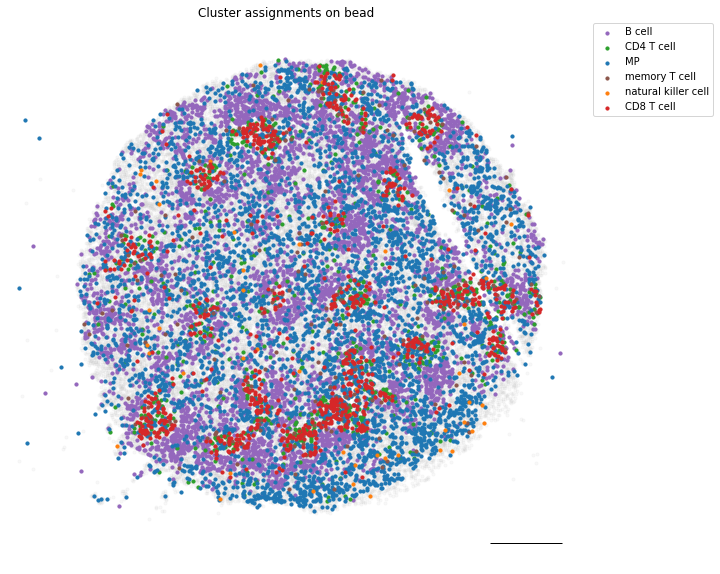

In [8]:
# Plot RCTD
point_size = 10

fig, ax = plt.subplots(figsize=(10, 10))

gray_filt = puckSpleen.s1_dge_fmtd
plt.scatter(
    [puckSpleen.bc_loc_dict_s1[i][0] for i in gray_filt.index],
    [puckSpleen.bc_loc_dict_s1[i][1] for i in gray_filt.index],
    s=point_size,
    alpha=0.05,
    c="gray",
)  # c=list(marco_filt['Marco']),

fn = "{}/spleen_rctd_clusters_aging.csv".format(directory)
cluster_labels = pd.read_csv(fn)
cluster_labels["cluster"] = cluster_labels["cell_label"]
cluster_num = len(list(set(cluster_labels.cluster)))

# Merge all macrophage labels
macrophage_dict = {
    "CD8 macrophage": "MP",
    "CD4 macrophage": "MP",
    "activated macrophage": "MP",
}
cluster_labels.cell_label = [
    macrophage_dict[i] if i in macrophage_dict else i for i in cluster_labels.cell_label
]
cluster_labels.cluster = [
    macrophage_dict[i] if i in macrophage_dict else i for i in cluster_labels.cluster
]

groups = cluster_labels.groupby(
    "cell_label"
)  # can change to translated to visualize by translation or clonotype
cell_type_list = list(set(cluster_labels.cluster))
colors_to_use = [sns.color_palette("deep")[idx] for idx in range(len(cell_type_list))]
colors_to_use_dict = {
    "CD8 T cell": sns.color_palette()[3],
    "natural killer cell": sns.color_palette()[1],
    "MP": sns.color_palette()[0],
    "memory T cell": sns.color_palette()[5],
    "CD4 T cell": sns.color_palette()[2],
    "B cell": sns.color_palette()[4],
}
# plot MP first
for name, group in groups:
    if name == "CD8 T cell":
        continue
    plt.scatter(
        group["x"],
        group["y"],
        s=point_size,
        label=name,
        marker="o",
        alpha=1,
        color=colors_to_use_dict[name],
    )

for name, group in groups:
    if name != "CD8 T cell":
        continue
    plt.scatter(
        group["x"],
        group["y"],
        s=point_size,
        label=name,
        marker="o",
        alpha=1,
        color=colors_to_use_dict[name],
    )

plt.title("Cluster assignments on bead")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.xlim([0, 6000])
plt.ylim([0, 6000])
plt.axis("off")
fontprops = fm.FontProperties(size=18)
scalebar = AnchoredSizeBar(
    ax.transData,
    pixels_needed,
    "",
    "lower right",
    pad=0.1,
    color="black",
    frameon=False,
    size_vertical=1,
    fontproperties=fontprops,
)

ax.add_artist(scalebar)
plt.show()

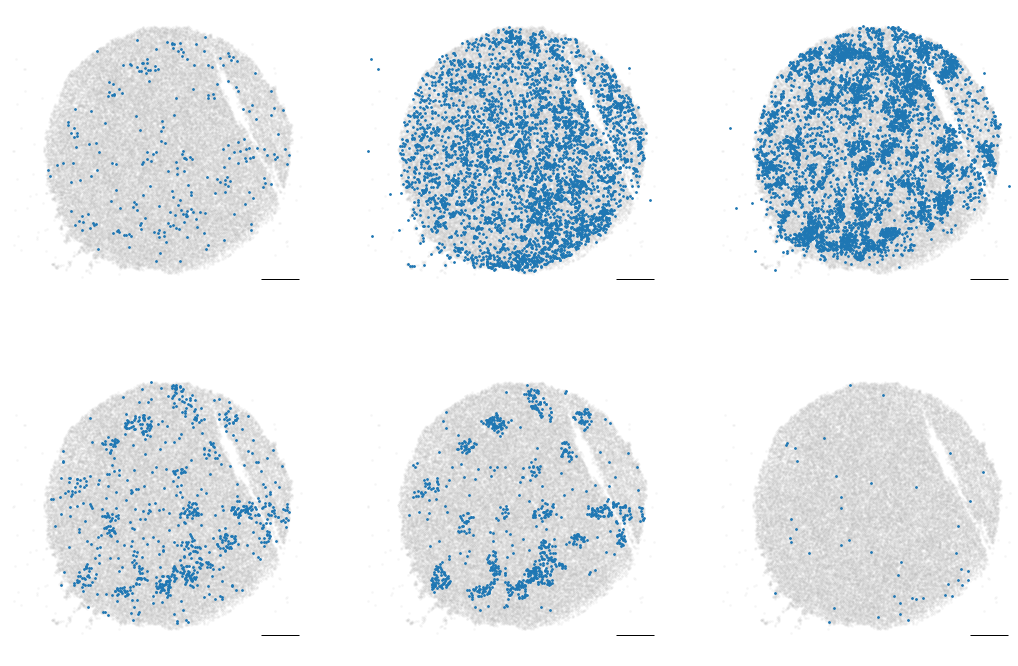

In [9]:
# Supplementary Figure 1a
fig, ax = plt.subplots(2, 3, figsize=(9 * 2, 6 * 2))

gray_filt = puckSpleen.s1_dge_fmtd
gray_filt_x = [puckSpleen.bc_loc_dict_s1[i][0] for i in gray_filt.index]
gray_filt_y = [puckSpleen.bc_loc_dict_s1[i][1] for i in gray_filt.index]

for idx in range(len(cell_type_list)):
    c = cell_type_list[idx]
    x = cluster_labels[cluster_labels.cluster == c].x
    y = cluster_labels[cluster_labels.cluster == c].y
    ax[math.floor(idx / 3), idx % 3].scatter(gray_filt_x,
                                             gray_filt_y,
                                             s=3,
                                             alpha=0.05,
                                             c='gray')
    ax[math.floor(idx / 3), idx % 3].scatter(x, y, s=3)
    ax[math.floor(idx / 3), idx % 3].axis('off')
    ax[math.floor(idx / 3), idx % 3].set_xlim([0, 6000])
    ax[math.floor(idx / 3), idx % 3].set_ylim([0, 6000])

    ######
    fontprops = fm.FontProperties(size=18)
    scalebar = AnchoredSizeBar(ax[math.floor(idx / 3), idx % 3].transData,
                               pixels_needed,
                               '',
                               'lower right',
                               pad=0.1,
                               color='black',
                               frameon=False,
                               size_vertical=1,
                               fontproperties=fontprops)

    ax[math.floor(idx / 3), idx % 3].add_artist(scalebar)
plt.axis('off')
plt.show()

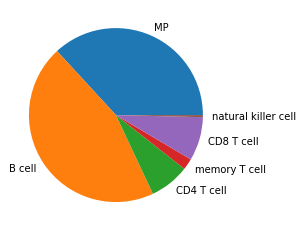

In [11]:
# Supplementary Figure 1b
plt.rcParams.update({'font.size': 10})
cter = Counter(cluster_labels.cell_label)
cell_type = list(cter.keys())
counts = list(cter.values())

#Using matplotlib
plot = plt.pie(counts, labels=cell_type)

# Figure 1d - Gene expression gaussian-filtered heatmap for visualizing the spatial distribution of gene markers

real life size: 91.23825
real life size: 85.84584999999998
real life size: 91.24085


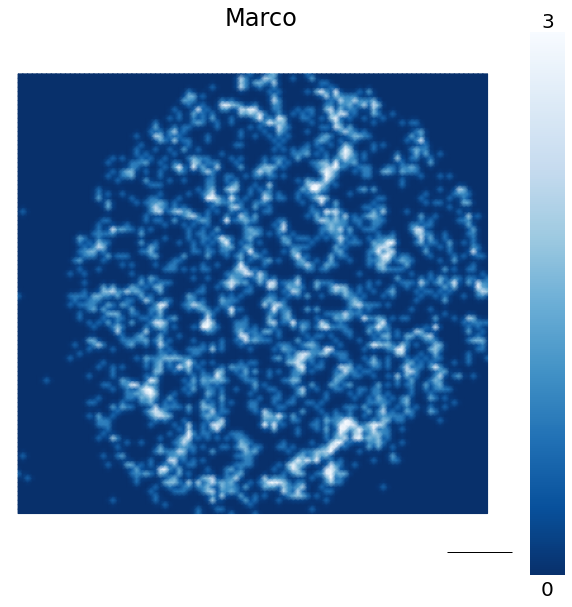

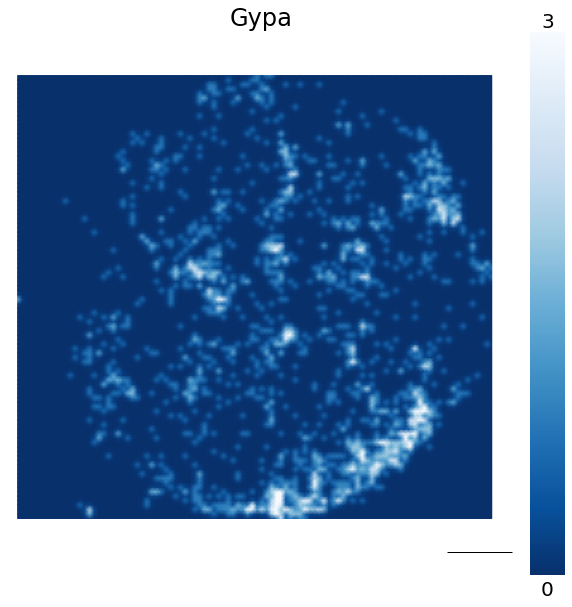

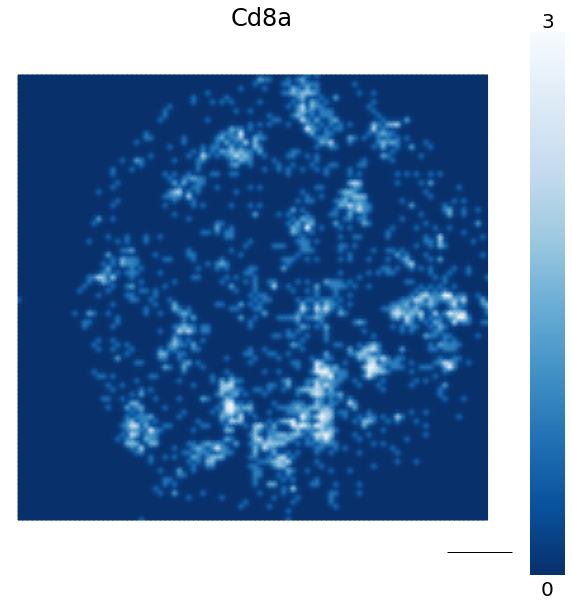

In [12]:
plt.rcParams.update({'font.size': 20})
color_map = plt.cm.get_cmap('Blues')
reversed_color_map = color_map.reversed()

nbins = 100

for gene in ['Marco', 'Gypa', 'Cd8a']:
    gene_filt = puckSpleen.s1_dge_fmtd[puckSpleen.s1_dge_fmtd[gene] > 0]
    x = [puckSpleen.bc_loc_dict_s1[i][0] for i in gene_filt.index]
    y = [puckSpleen.bc_loc_dict_s1[i][1] for i in gene_filt.index]
    gaussian_heat_plot(x, y, 0, 3, title=True, title_text=gene)

# Figure 1e and 1f - TCR constant and variable heatmaps

real life size: 84.77595
real life size: 84.77595
real life size: 169.1837
Beta
real life size: 85.08534999999999


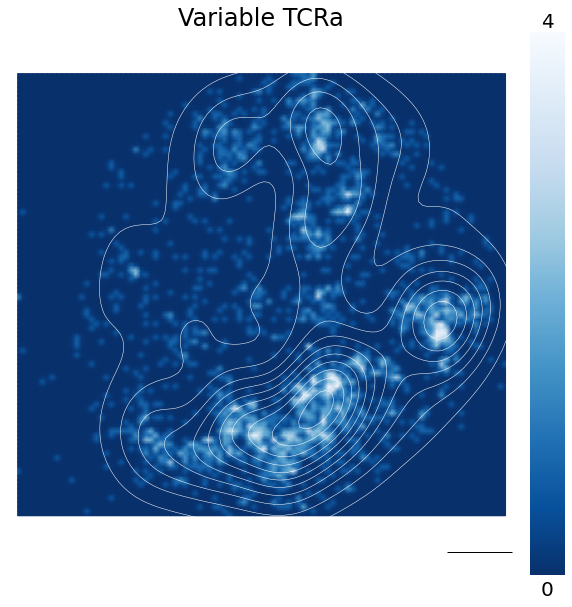

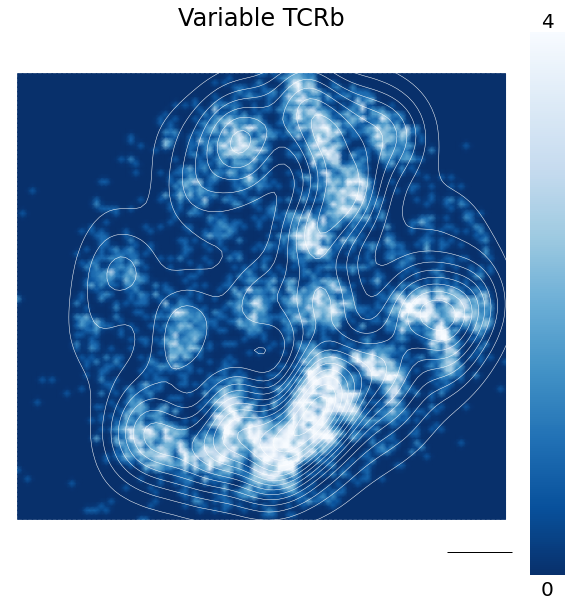

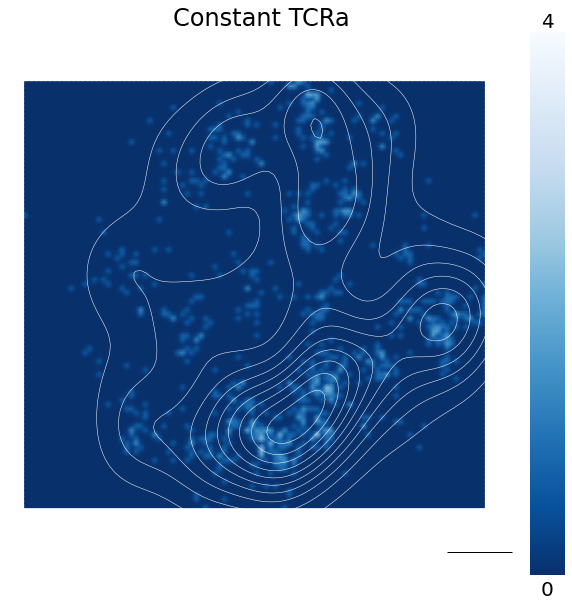

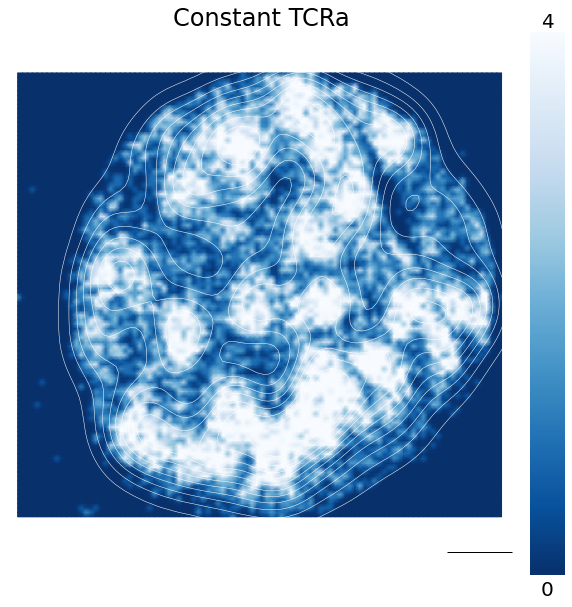

In [14]:
# Contour plot with gaussian smoothing
# Plot kdeplot on for Human or Spleen
# plot for figure
puck = puckSpleen
vmin_val = 0
vmax_val_alpha = 4
vmax_val_beta = 4

species = 'mouse'
if species == 'mouse':
    tcra_gene_name = 'Trac'
    tcrb_gene_name = 'Trbc2'
else:
    tcra_gene_name = 'Trac'
    tcrb_gene_name = 'Trbc2'

tcr_locs = list(set(list(sum(puck.tcr_loc_dict_s1_filtered3.values(),
                             []))))  # variable locations

tcr_locs_alpha = []  # variable locations
tcr_locs_beta = []
for tcr in puck.tcr_loc_dict_s1_filtered3:
    if tcr in puck.clonotypes['1a']:
        tcr_locs_alpha = tcr_locs_alpha + list(
            set(puck.tcr_loc_dict_s1_filtered3[tcr]))
    else:
        tcr_locs_beta = tcr_locs_beta + list(
            set(puck.tcr_loc_dict_s1_filtered3[tcr]))

color_map = plt.cm.get_cmap('Blues')
reversed_color_map = color_map.reversed()

point_size = 20
pixels_needed = 500 / 0.65

gaussian_heat_plot([float(i[0]) for i in tcr_locs_alpha],
                   [float(i[1]) for i in tcr_locs_alpha],
                   vmin_val,
                   vmax_val_alpha,
                   plot_contour=True,
                   title=True,
                   title_text='Variable TCRa')
gaussian_heat_plot([float(i[0]) for i in tcr_locs_beta],
                   [float(i[1]) for i in tcr_locs_beta],
                   vmin_val,
                   vmax_val_beta,
                   plot_contour=True,
                   title=True,
                   title_text='Variable TCRb')

gene_filt = puck.s1_dge_fmtd[puck.s1_dge_fmtd[tcra_gene_name] > 0]
x = [puck.bc_loc_dict_s1[i][0] for i in gene_filt.index]
y = [puck.bc_loc_dict_s1[i][1] for i in gene_filt.index]
gaussian_heat_plot(x,
                   y,
                   vmin_val,
                   vmax_val_alpha,
                   plot_contour=True,
                   title=True,
                   title_text='Constant TCRa')

print('Beta')

gene_filt = puck.s1_dge_fmtd[puck.s1_dge_fmtd[tcrb_gene_name] > 0]
x = [puck.bc_loc_dict_s1[i][0] for i in gene_filt.index]
y = [puck.bc_loc_dict_s1[i][1] for i in gene_filt.index]
gaussian_heat_plot(x,
                   y,
                   vmin_val,
                   vmax_val_beta,
                   plot_contour=True,
                   title=True,
                   title_text='Constant TCRa')

# Figure 1g - Variable recovery

TCR beta
10
[0.21337291854911578, 0.3862368257904526, 0.5378310214375788, 0.6507760532150776, 0.7504393673110721, 0.8292682926829268, 0.8921568627450981, 0.935251798561151, 0.9428571428571428, 1.0, [0.9807692307692307]]
TCR alpha
2
[0.6158854166666666, 0.8333333333333334, [1.0]]


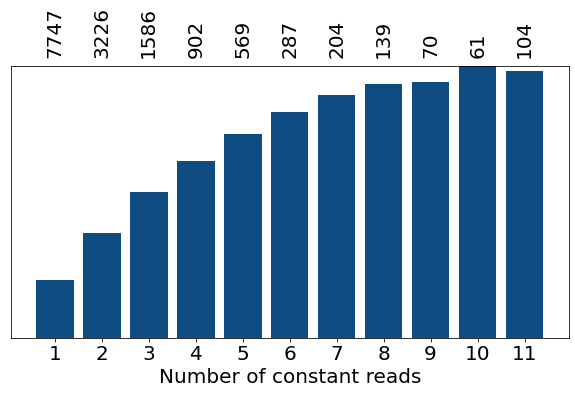

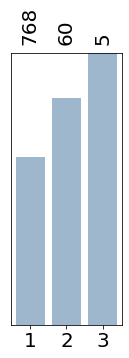

In [15]:
print('TCR beta')
plot_variable_vs_constant(puckSpleen.s1_dge_fmtd,
                          'tcr_b',
                          puckSpleen.tcr_loc_dict_s1_filtered3,
                          puckSpleen.loc_to_bc_s1,
                          human=False,
                          cutoff=10,
                          plot_histogram=False)

print('TCR alpha')
plot_variable_vs_constant(puckSpleen.s1_dge_fmtd,
                          'tcr_a',
                          puckSpleen.tcr_loc_dict_s1_filtered3,
                          puckSpleen.loc_to_bc_s1,
                          human=False,
                          cutoff=2,
                          plot_histogram=False)

# Supplementary Figure 2a-b and Supplementary Table 4

0.3714627341570347 fraction of constant that also have variable 
0.24717285945072698 new to constant


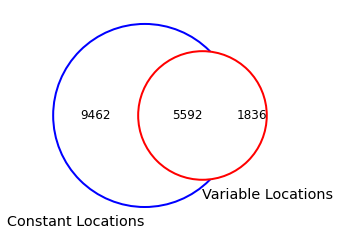

In [5]:
# Supplementary Figure 2a
plt.rcParams.update({'font.size': 12})
constant_locs = []
variable_locs = []
constant_locs = [
    puckSpleen.bc_loc_dict_s1[i]
    for i in puckSpleen.s1_dge_fmtd[(puckSpleen.s1_dge_fmtd['Trac'] > 0) | (
        puckSpleen.s1_dge_fmtd['Trbc2'] > 0)].index
]
for tcr in puckSpleen.tcr_loc_dict_s1_filtered3:
    variable_locs = variable_locs + \
    puckSpleen.tcr_loc_dict_s1_filtered3[tcr]

constant_locs = set(constant_locs)
variable_locs = set(variable_locs)

shared_locs = set(list(constant_locs & variable_locs))
print(
    len(shared_locs) / len(constant_locs),
    'fraction of constant that also have variable ')
print(
    len([i
         for i in variable_locs if i not in shared_locs]) / len(variable_locs),
    'new to constant')

#####
set1 = constant_locs
set2 = variable_locs

v = venn2([set1, set2], ('Constant Locations', 'Variable Locations'))
c = venn2_circles([set1, set2])
c[0].set_color("white")
c[0].set_ls('solid')
c[0].set_edgecolor('blue')

c[1].set_color("white")
c[1].set_ls('solid')
c[1].set_edgecolor('red')
plt.show()

CASSRANYEQYF
RASSRATYEQYF
CASSI_EQYF
CASRQQDTQYF
CASRADYEQYF
6381
2182


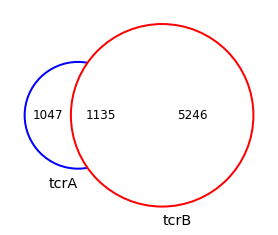

0.13254700455447857


In [6]:
# Supplementary Figure 2b
locs_all_a = []
locs_all_b = []
for cl in puckSpleen.tcr_loc_dict_s1_filtered3:
    if cl in puckSpleen.clonotypes["1a"]:
        locs_all_a = locs_all_a + puckSpleen.tcr_loc_dict_s1_filtered3[cl]
    elif cl in puckSpleen.clonotypes["1b"]:
        locs_all_b = locs_all_b + puckSpleen.tcr_loc_dict_s1_filtered3[cl]
        print(cl)
locs_all_a = set(locs_all_a)
locs_all_b = set(locs_all_b)

# Circos plot
df_use = puckSpleen.df_s1_filtered3

all_bc = list(puckSpleen.s1_dge_fmtd.index)
bc_s1_tcrb = set([i for i in find_specific_barcodes("tcr_b", df_use) if i in all_bc])
bc_s1_tcra = set([i for i in find_specific_barcodes("tcr_a", df_use) if i in all_bc])
paired_bcs = list(set(bc_s1_tcrb) & set(bc_s1_tcra))
paired_df = puckSpleen.df_s1_filtered3[
    (df_use.tcr_a.map(len) > 0) & (df_use.tcr_b.map(len) > 0)
]

circos_plot_df = paired_df.copy(deep=True)
circos_plot_df["tcr_a"] = paired_df.tcr_a
circos_plot_df["tcr_b"] = paired_df.tcr_b

tcr_a_hamming = []
tcr_b_hamming = []
for i in circos_plot_df["tcr_a"]:
    i = ast.literal_eval(i)
    this_list = []
    for j in i:
        this_list.append(j)
    tcr_a_hamming.append(this_list)

for i in circos_plot_df["tcr_b"]:
    i = ast.literal_eval(i)
    this_list = []
    for j in i:
        this_list.append(j)
    tcr_b_hamming.append(list(set(this_list)))

circos_plot_df["tcr_a_hamming"] = tcr_a_hamming
circos_plot_df["tcr_b_hamming"] = tcr_b_hamming

# SUPPLEMENTARY TABLE 4 IS CIRCOS_PLOT_DF

tcr_bc_counter_dict = {}  # A dictionary for counting (tcr,bc) pairs
for cl in puckSpleen.tcr_loc_dict_s1_filtered3:
    cl_name = cl
    for loc in puckSpleen.tcr_loc_dict_s1_filtered3[cl_name]:
        bc = puckSpleen.loc_to_bc_s1[loc]
        if (cl, bc) not in tcr_bc_counter_dict:
            tcr_bc_counter_dict[(cl_name, bc)] = 0
        tcr_bc_counter_dict[tuple((cl_name, bc))] += 1

circos_bcs = list(circos_plot_df["bead_barcodes"])
circos_a = list(circos_plot_df["tcr_a_hamming"])
circos_b = list(circos_plot_df["tcr_b_hamming"])
circos_plot_df["tcr_a_top"] = [
    find_highest_expressing_clonotype(circos_bcs[idx], circos_a[idx])
    for idx in range(len(circos_plot_df))
]
circos_plot_df["tcr_b_top"] = [
    find_highest_expressing_clonotype(circos_bcs[idx], circos_b[idx])
    for idx in range(len(circos_plot_df))
]

# circos_plot_df['tcr_a_hamming'].apply(pd.Series).reset_index().melt(id_vars='index').dropna()[['index', 'value']].set_index('index')
circos_plot_df = (
    circos_plot_df.groupby(by=["tcr_a_top", "tcr_b_top"])
    .count()[["bead_barcodes"]]
    .rename(columns={"bead_barcodes": "Count"})
    .reset_index()
)

# Plot pairing
plt.rcParams.update({"font.size": 12})
all_bc = list(puckSpleen.s1_dge_fmtd.index)
bc_s1_tcrb = locs_all_b
bc_s1_tcra = locs_all_a
paired_bcs = list(set(bc_s1_tcrb) & set(bc_s1_tcra))
# Second way
v = venn2([bc_s1_tcra, bc_s1_tcrb], set_labels=["tcrA", "tcrB"])
c = venn2_circles([bc_s1_tcra, bc_s1_tcrb])
c[0].set_color("white")
c[0].set_ls("solid")
c[0].set_edgecolor("blue")

c[1].set_color("white")
c[1].set_ls("solid")
c[1].set_edgecolor("red")

plt.show()
print(len(paired_bcs) / (len(bc_s1_tcrb) + len(bc_s1_tcra)))

# Supplementary Figure 2c-e

LinregressResult(slope=0.5613947778558579, intercept=-0.40929479433683413, rvalue=0.8394434218755716, pvalue=0.0, stderr=0.007271734103279579)


Text(0, 0.5, 'variable')

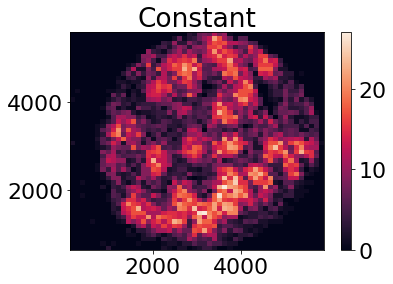

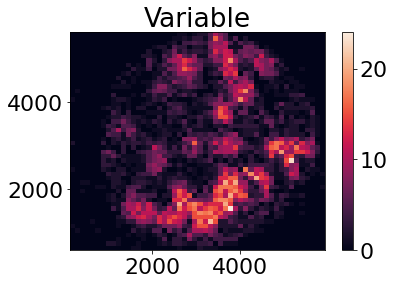

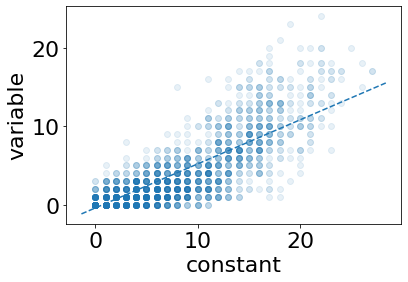

In [23]:
# Find beads with constant Alpha or Beta sequence
puck = puckSpleen
constant_seq_present = puck.s1_dge_fmtd[(puck.s1_dge_fmtd['Trac'] > 0) |
                                        (puck.s1_dge_fmtd['Trbc2'] > 0)]
constant_seq_present_bcs = []
for bc in constant_seq_present.index:
    constant_seq_present_bcs = constant_seq_present_bcs + [bc]

# Find beads with variable Alpha or Beta sequence
variable_seq_present = []
for tcr in puck.tcr_loc_dict_s1_filtered3:
    for loc in set(puck.tcr_loc_dict_s1_filtered3[tcr]):
        variable_seq_present.append(loc)
variable_seq_present = list(set(variable_seq_present))

cmap_to_use = sns.color_palette("rocket", as_cmap=True)
## Constant
x = [i[0] for i in [puck.bc_loc_dict_s1[i] for i in constant_seq_present_bcs]]
y = [i[1] for i in [puck.bc_loc_dict_s1[i] for i in constant_seq_present_bcs]]
heatmap_constant, xedges, yedges = np.histogram2d(x, y, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.figure()
plt.imshow(heatmap_constant.T, extent=extent, cmap=cmap_to_use, origin='lower')
plt.colorbar()
plt.title('Constant')

## Variable
x_var = [i[0] for i in variable_seq_present]
y_var = [i[1] for i in variable_seq_present]
heatmap_variable, xedges, yedges = np.histogram2d(x_var, y_var, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.figure()
plt.imshow(heatmap_variable.T, extent=extent, cmap=cmap_to_use, origin='lower')
plt.colorbar()
plt.title('Variable')

## Plot correlation between the two
plt.rcParams.update({'font.size': 22})

x = heatmap_constant.reshape(-1)
y = heatmap_variable.reshape(-1)

plt.figure()
plt.scatter(x, y, alpha=0.1)
abline(scipy.stats.linregress(x, y)[0], scipy.stats.linregress(x, y)[1])
print(scipy.stats.linregress(x, y))
plt.xlabel('constant')
plt.ylabel('variable')

# Load in RCC pucks

In [14]:
# Save or load pucks that you have been analyzing

# save = False  # Set to true if you want to re-save everything
# # again and false if you want to load a previously saved puck

# # all_puck_names = [
# #     '2020-09-02_Puck_200727_08',
# #     '2020-09-02_Puck_200727_09',
# #     '2020-09-02_Puck_200727_10',  # Post-treatment
# #     '2020-08-31_Puck_200727_02',  # Spleen
# #     '2020-09-02_Puck_200727_12',
# #     '2020-09-02_Puck_200727_12'
# # ]  # Pre-treatment
# puck_name = '2020-09-02_Puck_200727_10'

# if save:
#     with open('{}_object.pickle'.format(puck_name), 'wb') as handle:
#         pkl.dump(puck8, handle, protocol=pkl.HIGHEST_PROTOCOL)
# else:
#     with open('{}_object.pickle'.format(puck_name), 'rb') as handle:
#         puck10 = pkl.load(handle)


<IPython.core.display.Javascript object>

In [ ]:
# Post-treatment RCC
# For resave and resave_sparse
# Set True if this is your first time loading a puck.
# Otherwise you can set to False.
load_pre_treatment = False
post_cluster_num_to_name_list = [
    "Tumor",
    "B",
    "MGP",
    "RNA28S5",
    "Lung",
    "TIL Chemokines",
    "IghM B",
    "No markers",
    "Igll5 and Iglv3.25",
    "No markers",
    "B",
    "B",
    "B",
    "RBC",
    "TIL Chemokines",
    "B",
    "B",
    "B",
    "B",
    "B",
    "B",
    "Ftl",
    "Tmsb4x",
]
post_cell_type_list = ["Lung", "Tumor", "TIL Chemokines"]

puck8 = PuckReplicate(
    puck_name="2020-09-02_Puck_200727_08",
    genome="hg19",
    clonotype_sample_name="B10_8",
    clonotype_fastq_name="B10-8_S1",
    umi_filter_number=1,
    rctd_fn="Aggregated_clusterassignments.csv",
    cluster_num_to_name_list=post_cluster_num_to_name_list,
    cell_type_list=post_cell_type_list,
    abbrev_rep_name="rep8",
    rcc=True,
    resave=False,
    resave_sparse=False,
)

puck9 = PuckReplicate(
    puck_name="2020-09-02_Puck_200727_09",
    genome="hg19",
    clonotype_sample_name="B10_9",
    clonotype_fastq_name="B10-9_S2",
    umi_filter_number=1,
    rctd_fn="Aggregated_clusterassignments.csv",
    cluster_num_to_name_list=post_cluster_num_to_name_list,
    cell_type_list=post_cell_type_list,
    abbrev_rep_name="rep9",
    rcc=True,
    resave=False,
    resave_sparse=False,
)

puck10 = PuckReplicate(
    puck_name="2020-09-02_Puck_200727_10",
    genome="hg19",
    clonotype_sample_name="B10_10",
    clonotype_fastq_name="B10-10_S1",
    umi_filter_number=1,
    rctd_fn="Aggregated_clusterassignments.csv",
    cluster_num_to_name_list=post_cluster_num_to_name_list,
    cell_type_list=post_cell_type_list,
    abbrev_rep_name="rep10",
    rcc=True,
    resave=False,
    resave_sparse=False,
)

if load_pre_treatment:
    pre_cluster_num_to_name_list = [
        "None",
        "None",
        "None",
        "Tumor",
        "None",
        "None",
        "None",
        "None",
        "None",
        "None",
        "None",
        "None",
        "None",
        "None",
        "Immune",
        "None",
        "None",
        "None",
        "None",
        "None",
        "None",
        "None",
        "None",
        "None",
        "None",
        "None",
        "None",
        "None",
        "None",
        "None",
        "None",
        "None",
        "None",
        "None",
        "None",
    ]
    pre_cell_type_list = ["", "Tumor", "Immune"]

    puck12 = PuckReplicate(
        puck_name="2020-09-02_Puck_200727_12",
        genome="hg19",
        clonotype_sample_name="B10_12",
        clonotype_fastq_name="B10-12_S1",
        umi_filter_number=1,
        rctd_fn="Aggregated_clusterassignments_pretreatment.csv",
        cluster_num_to_name_list=pre_cluster_num_to_name_list,
        cell_type_list=pre_cell_type_list,
        abbrev_rep_name="rep12",
        rcc=True,
        resave=False,
        resave_sparse=False,
    )

    puck13 = PuckReplicate(
        puck_name="2020-09-02_Puck_200727_13",
        genome="hg19",
        clonotype_sample_name="B10_13",
        clonotype_fastq_name="B10-13_S2",
        umi_filter_number=1,
        rctd_fn="Aggregated_clusterassignments_pretreatment.csv",
        cluster_num_to_name_list=pre_cluster_num_to_name_list,
        cell_type_list=pre_cell_type_list,
        abbrev_rep_name="rep13",
        rcc=True,
        resave=False,
        resave_sparse=False,
    )

# Figure 2b - Spatial reconstruction of Slide-TCR-seq array (RCC) and Supplementary Figure 3a

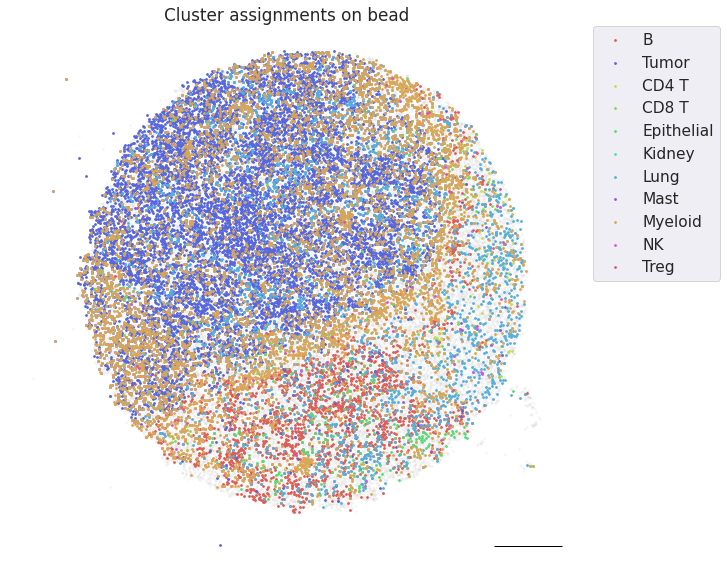

<IPython.core.display.Javascript object>

In [165]:
# Plot RCTD
puck = puck8

condensed_cell_type_names = {
    "Bcell": "B",
    "MastCell": "Mast",
    "MyeloidCell_02_CD11c_CD14": "Myeloid",
    "Myeloid_01_CD11c": "Myeloid",
    "Myeloid_03_CD16": "Myeloid",
    "Myeloid_04_CD14_CD16": "Myeloid",
    "Myeloid_DC1_CD141": "Myeloid",
    "Myeloid_pDC": "Myeloid",
    "NK": "NK",
    "NKT": "NK",
    "NonImmuneCell": "Lung",
    "PlasmaCell": "B",
    "Tcell_CD4": "CD4 T",
    "Tcell_CD8": "CD8 T",
    "Tcell_Treg": "Treg",
    "TumorCell_CA9": "Tumor",
    "Kidney_DistalTubule": "Kidney",
    "Kidney_ProximalTubule": "Kidney",
    "Epithelial_EPCAM": "Epithelial",
}

point_size = 3

fig, ax = plt.subplots(figsize=(10, 10))

gray_filt = puck.s1_dge_fmtd
plt.scatter(
    [puck.bc_loc_dict_s1[i][0] for i in gray_filt.index],
    [puck.bc_loc_dict_s1[i][1] for i in gray_filt.index],
    s=point_size,
    alpha=0.05,
    c="gray",
)  # c=list(marco_filt['Marco']),

fn = "{}rcc_rctd_clusters_{}.csv".format(directory, puck.puck_name)
cluster_labels = pd.read_csv(fn)
cluster_labels["cluster"] = cluster_labels["cell_label"]

cluster_num = len(list(set(cluster_labels.cluster)))

cell_type_list = sorted(list(set(list(condensed_cell_type_names.values()))))
# move myeloid to position 1 for coloring and tumor to purple
cell_type_list.remove("Myeloid")
cell_type_list.insert(1, "Myeloid")
cell_type_list.remove("Tumor")
cell_type_list.insert(7, "Tumor")

cluster_labels["condensed"] = [
    condensed_cell_type_names[i] for i in cluster_labels["cluster"]
]
colors_to_use_condensed = [
    sns.color_palette("hls", len(cell_type_list))[idx]
    for idx in range(len(cell_type_list))
]

groups = cluster_labels.groupby(
    "cell_label"
)  # can change to translated to visualize by translation or clonotype
groups_condensed = cluster_labels.groupby(
    "condensed"
)  # can change to translated to visualize by translation or clonotype

##### CONDENSED VERSIONS

for name, group in groups_condensed:  # Plot tumor first
    if name in ["Tumor", "B"]:
        plt.scatter(
            group["x"],
            group["y"],
            s=point_size,
            label=name,
            marker="o",
            alpha=1,
            color=colors_to_use_condensed[cell_type_list.index(name)],
        )

for name, group in groups_condensed:
    if name not in ["Tumor", "B"]:
        plt.scatter(
            group["x"],
            group["y"],
            s=point_size,
            label=name,
            marker="o",
            alpha=1,
            color=colors_to_use_condensed[cell_type_list.index(name)],
        )

######
fontprops = fm.FontProperties(size=18)
scalebar = AnchoredSizeBar(
    ax.transData,
    pixels_needed,
    "",
    "lower right",
    pad=0.1,
    color="black",
    frameon=False,
    size_vertical=1,
    fontproperties=fontprops,
)

ax.add_artist(scalebar)

plt.title("Cluster assignments on bead")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.axis("off")
plt.show()

# Supplementary Figure 3c

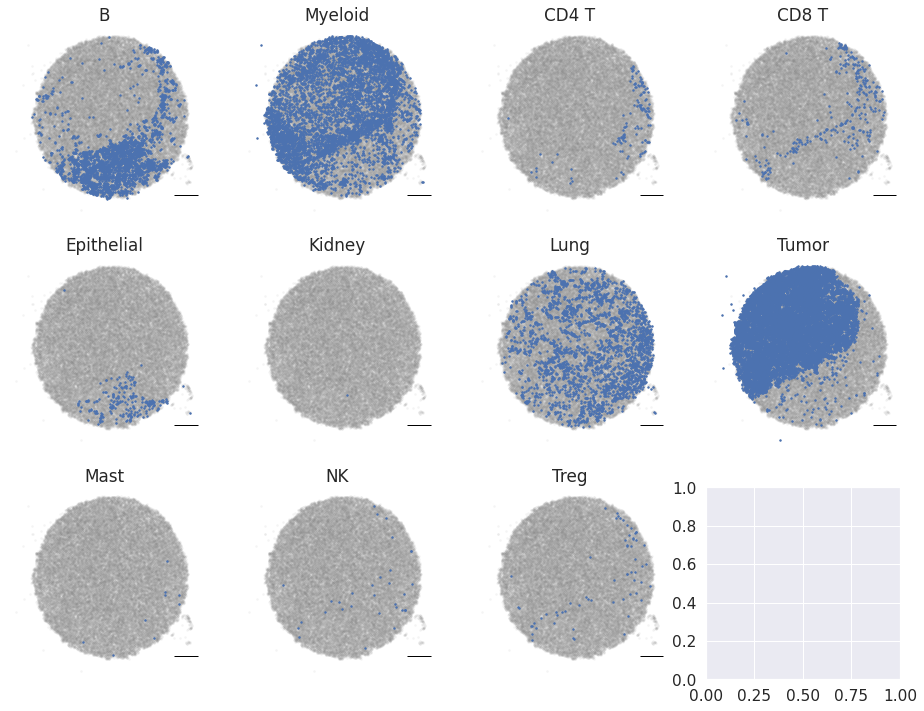

<IPython.core.display.Javascript object>

In [167]:
# Plot each cell type individually
puck = puck8
fig, ax = plt.subplots(3, 4, figsize=(8 * 2, 6 * 2))

gray_filt = puck.s1_dge_fmtd
gray_filt_x = [puck.bc_loc_dict_s1[i][0] for i in gray_filt.index]
gray_filt_y = [puck.bc_loc_dict_s1[i][1] for i in gray_filt.index]

for idx, c in enumerate(cell_type_list):
    x = cluster_labels[cluster_labels.condensed == c].x
    y = cluster_labels[cluster_labels.condensed == c].y
    ax[math.floor(idx / 4), idx % 4].scatter(
        gray_filt_x, gray_filt_y, s=3, alpha=0.05, c="gray"
    )
    ax[math.floor(idx / 4), idx % 4].scatter(x, y, s=2)
    ax[math.floor(idx / 4), idx % 4].axis("off")
    fontprops = fm.FontProperties(size=18)
    scalebar = AnchoredSizeBar(
        ax[math.floor(idx / 4), idx % 4].transData,
        pixels_needed,
        "",
        "lower right",
        pad=0.1,
        color="black",
        frameon=False,
        size_vertical=1,
        fontproperties=fontprops,
    )

    ax[math.floor(idx / 4), idx % 4].add_artist(scalebar)

    ax[math.floor(idx / 4), idx % 4].set_title(c)

# Supplementary Figure 3d

In [157]:
# Generate nearest cell types vectors(RCTD)
d = 50 / 0.65
cl_cell_counter = {}

fn = "{}rcc_rctd_clusters_{}.csv".format(directory, puck8.puck_name)
# fn = 'rcc_rctd_clusters_{}.csv'.format(puck13.puck_name)
cluster_labels = pd.read_csv(fn)
cluster_labels.rename(columns={"cell_label": "cluster_name"}, inplace=True)
cell_type_list = list(set(cluster_labels.cluster_name))

# fn = 'rcc_rctd_clusters_{}.csv'.format(puck12.puck_name)
cluster_labels = pd.read_csv(fn)
cluster_labels.rename(columns={"cell_label": "cluster_name"}, inplace=True)
cell_type_list = list(set(cell_type_list + list(set(cluster_labels.cluster_name))))

cluster_name_to_num_dict = {cell_type_list[i]: i for i in range(len(cell_type_list))}

for puck in tqdm([puck8, puck9, puck10]):  # [puck8,puck9,puck10]
    fn = "{}rcc_rctd_clusters_{}.csv".format(directory, puck.puck_name)
    cluster_labels = pd.read_csv(fn)
    cluster_labels.rename(columns={"cell_label": "cluster_name"}, inplace=True)

    barcodes = [
        puck.loc_to_bc_s1[i, j] for i, j in zip(cluster_labels.x, cluster_labels.y)
    ]
    cluster_num = [cluster_name_to_num_dict[i] for i in cluster_labels.cluster_name]
    cluster_labels["cluster"] = cluster_num
    cluster_labels["barcode"] = barcodes
    bc_to_cluster_label_dict = dict(zip(cluster_labels.barcode, cluster_labels.cluster))
    loc_to_cluster_dict = {
        puck.bc_loc_dict_s1[i]: bc_to_cluster_label_dict[i]
        for i in list(bc_to_cluster_label_dict.keys())
    }
    puck.loc_cluster_dict = loc_to_cluster_dict

    # Find nearest beads and generate dictionary of normalized nearest neighbors vectors
    # for every point

    tcr_locs = []
    for cl in puck.tcr_loc_dict_s1_filtered3:
        for loc in set(puck.tcr_loc_dict_s1_filtered3[cl]):
            tcr_locs.append(loc)
    tcr_locs = list(set(tcr_locs))
    distarray = cdist(
        tcr_locs, list(puck.loc_to_bc_s1.keys())
    )  # CAN CHANGE TO TUMOR BEADS FOR JUST IN TUMOR

    loc_list_sort = sorted(puck.tumor_beads, key=lambda x: x[0])
    loc_list_sort_x = [i[0] for i in loc_list_sort]

    tumor_beads_loc_to_index = {}
    for i in range(len(puck.tumor_beads)):
        tumor_beads_loc_to_index[puck.tumor_beads[i]] = i

    random_tumor_dict = {}
    for each_loc in tqdm(tcr_locs):

        # Filter for x values within distance in either direction to reduce number of points needed to search.
        x_lower_bound = each_loc[0] - d
        x_upper_bound = each_loc[0] + d

        locs_within_bounds = loc_list_sort[
            find_le(loc_list_sort_x, x_lower_bound) : find_ge(
                loc_list_sort_x, x_upper_bound
            )
            + 1
        ]
        locs_within_bounds = [
            loc
            for loc in locs_within_bounds
            if ((each_loc[0] - loc[0]) ** 2 + (each_loc[1] - loc[1]) ** 2) ** 0.5 < d
        ]
        cl_convert = bc_list_to_clusters_vector(
            [puck.loc_to_bc_s1[loc] for loc in locs_within_bounds],
            cell_type_list,
            bc_to_cluster_label_dict,
            verbose=False,
        )
        random_tumor_dict[each_loc] = np.array(cl_convert)
    puck.random_tumor_dict = random_tumor_dict

    for tcr in tqdm(puck.tcr_loc_dict_s1_filtered3):
        # only look at TCRbeta
        if tcr not in puck.clonotypes["1b"]:
            continue
        if len(set(puck.tcr_loc_dict_s1_filtered3[tcr])) < 10:
            continue
        if tcr not in cl_cell_counter:
            cl_cell_counter[tcr] = np.array([0] * len(cell_type_list))
        for loc in set(puck.tcr_loc_dict_s1_filtered3[tcr]):
            cl_cell_counter[tcr] = cl_cell_counter[tcr] + np.array(
                random_tumor_dict[loc]
            )
    puck.cluster_labels = cluster_labels

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1253 [00:00<?, ?it/s]

  0%|          | 0/1010 [00:00<?, ?it/s]

  0%|          | 0/1086 [00:00<?, ?it/s]

  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/949 [00:00<?, ?it/s]

  0%|          | 0/673 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [158]:
# Clean up cell type names
pretty_cell_type_names = {
    "Bcell": "B",
    "MastCell": "Mast",
    "MyeloidCell_02_CD11c_CD14": "Myeloid CD11c CD14",
    "Myeloid_01_CD11c": "Myeloid CD11c",
    "Myeloid_03_CD16": "Myeloid CD16",
    "Myeloid_04_CD14_CD16": "Myeloid CD14 CD16",
    "Myeloid_DC1_CD141": "Myeloid DC CD141",
    "Myeloid_pDC": "Myeloid pDC",
    "NK": "NK",
    "NKT": "NKT",
    "NonImmuneCell": "Lung",
    "PlasmaCell": "Plasma B",
    "Tcell_CD4": "CD4 T",
    "Tcell_CD8": "CD8 T",
    "Tcell_Treg": "Treg",
    "TumorCell_CA9": "Tumor",
    "Kidney_DistalTubule": "Kidney",
    "Kidney_ProximalTubule": "Kidney",
    "Epithelial_EPCAM": "Epithelial",
}

<IPython.core.display.Javascript object>

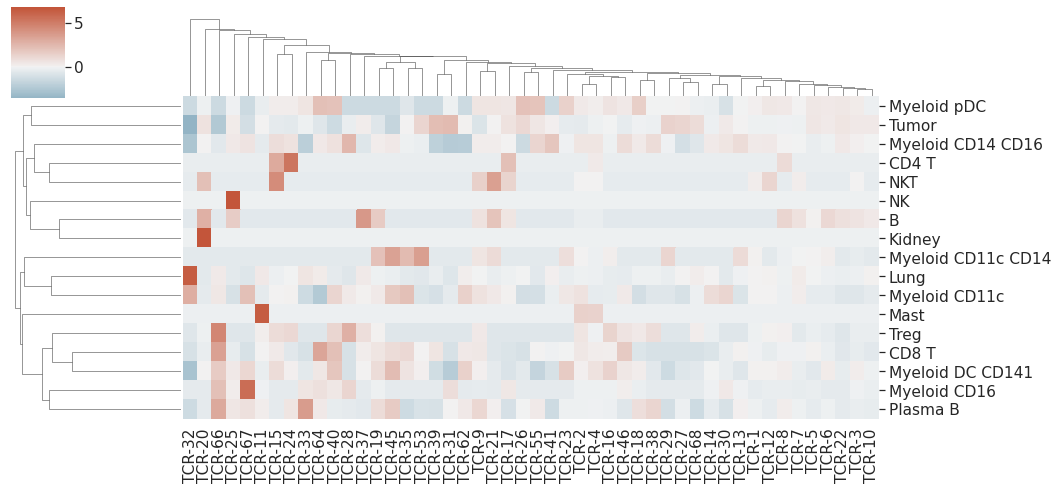

<IPython.core.display.Javascript object>

In [160]:
# Make clustermap
sns.set(font_scale=1.4)
agg_interactions = pd.DataFrame.from_dict(cl_cell_counter)
agg_interactions.columns = [pretty_clonotype_name[i] for i in agg_interactions.columns]
agg_interactions.index = [pretty_cell_type_names[i] for i in cell_type_list]
agg_interactions_no_zero = agg_interactions.loc[
    (agg_interactions.sum(axis=1) != 0), (agg_interactions.sum(axis=0) != 0)
]

for col in agg_interactions_no_zero.columns:
    agg_interactions_no_zero[col] = agg_interactions_no_zero[col] / sum(
        agg_interactions_no_zero[col]
    )

set_cmap = sns.diverging_palette(230, 20, as_cmap=True)

agg_interactions_no_zero.sort_index(inplace=True)
# For post-treatment, use this:
g = sns.clustermap(
    agg_interactions_no_zero,
    z_score=0,
    yticklabels=True,
    xticklabels=True,
    cmap=set_cmap,
    center=0,
    figsize=(15, 7),
)

# Supplementary Table 6

In [22]:
# To make Supplementary Table 6
tcrs_all = {}
for puck in [puck12, puck13]:
    for tcr in puck.tcr_loc_dict_s1_filtered3:
        if tcr not in puck.clonotypes["1b"]:
            continue
        if tcr not in tcrs_all:
            tcrs_all[tcr] = []
        tcrs_all[tcr] = tcrs_all[tcr] + list(
            set(puck.tcr_loc_dict_s1_filtered3[tcr])
        )  # fraction of beads, not umis
sum_all = 0
for tcr in tcrs_all:
    sum_all += len(tcrs_all[tcr])

tcr_name = []
fraction_all = []
for tcr in tcrs_all:
    if len(tcrs_all[tcr]) == 0:
        continue
    fraction = len(tcrs_all[tcr]) / sum_all
    #     if fraction > 0.09: #tcr == 'CASSVTGETGELFF':
    # print(fraction,tcr)
    tcr_name.append(tcr)
    fraction_all.append(fraction)

clonotype_fractions = pd.DataFrame.from_dict(
    {"clonotype": tcr_name, "fraction": fraction_all}
)
clonotype_fractions.sort_values("fraction", ascending=False, inplace=True)
clonotype_fractions.reset_index(inplace=True)
clonotype_fractions.drop(columns=["index"], inplace=True)
clonotype_fractions["name"] = [
    "TCR-" + str(i + 1133) for i in clonotype_fractions.index
]
clonotype_fractions.to_csv(
    "{}pre_treatment_clonotype_fraction_slide_seq.csv".format(directory)
)

# Fraction calculation for betas for each clonotype across all pucks
tcrs_all = {}
for puck in [puck8, puck9, puck10]:
    for tcr in puck.tcr_loc_dict_s1_filtered3:
        if tcr not in puck.clonotypes["1b"]:
            continue
        if tcr not in tcrs_all:
            tcrs_all[tcr] = []
        tcrs_all[tcr] = tcrs_all[tcr] + list(
            set(puck.tcr_loc_dict_s1_filtered3[tcr])
        )  # fraction of beads, not umis
sum_all = 0
for tcr in tcrs_all:
    sum_all += len(tcrs_all[tcr])

tcr_name = []
fraction_all = []
for tcr in tcrs_all:
    if len(tcrs_all[tcr]) == 0:
        continue
    fraction = len(tcrs_all[tcr]) / sum_all
    #     if fraction > 0.09: #tcr == 'CASSVTGETGELFF':
    # print(fraction,tcr)
    tcr_name.append(tcr)
    fraction_all.append(fraction)

clonotype_fractions = pd.DataFrame.from_dict(
    {"clonotype": tcr_name, "fraction": fraction_all}
)
clonotype_fractions.sort_values("fraction", ascending=False, inplace=True)
clonotype_fractions.reset_index(inplace=True)
clonotype_fractions.drop(columns=["index"], inplace=True)
# clonotype_fractions['name'] = ['TCR-'+str(i+1) for i in clonotype_fractions.index]
clonotype_fractions["name"] = [
    "TCR-" + str(i + 1133) for i in clonotype_fractions.index
]
clonotype_fractions.to_csv(
    "{}post_treatment_clonotype_fraction_slide_seq.csv".format(directory)
)

<IPython.core.display.Javascript object>

# Figure 2c -  Cumulative distribution function (CDF) showing the diversity and abundance of clonotypes and Supplementary Figure 4

(0.7488400462106772, 1.699121482548401e-12)

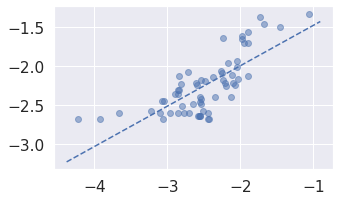

<IPython.core.display.Javascript object>

In [23]:
# Supplementary Figure 4a
pre_treatment_df = pd.read_csv(
    '{}pre_treatment_clonotype_fraction_slide_seq.csv'.format(directory))
post_treatment_df = pd.read_csv(
    '{}post_treatment_clonotype_fraction_slide_seq.csv'.format(directory))
post_treatment_df = post_treatment_df[
    post_treatment_df.fraction > 0.00018889308651303364 *
    10]  # To filter for at least 10 counts in Slide-seq

post_treatment_dict = dict(
    zip(post_treatment_df.clonotype, post_treatment_df.fraction))
post_treatment_dict_bulk = dict(zip(post_bulk_beta.cdr3, post_bulk_beta.Freq))

values_in_slide_seq = []
values_in_bulk = []
for cl in post_treatment_dict:
    if cl in post_treatment_dict_bulk:
        values_in_slide_seq.append(post_treatment_dict[cl])
        values_in_bulk.append(post_treatment_dict_bulk[cl])

x = np.log10(values_in_bulk)
y = np.log10(values_in_slide_seq)
fig, ax = plt.subplots(figsize=(5, 3))
plt.scatter(x, y, alpha=0.5)
x_vals = np.array(ax.get_xlim())
y_vals = scipy.stats.linregress(
    x, y)[1] + scipy.stats.linregress(x, y)[0] * x_vals
ax.plot(x_vals, y_vals, '--')
pearsonr(x, y)

r 0.41394283000776266 pval 1.7621930963590136e-06
r 0.3632640492390351 pval 3.914446680973122e-05
r 0.35227540109430866 pval 0.00018479060136278506


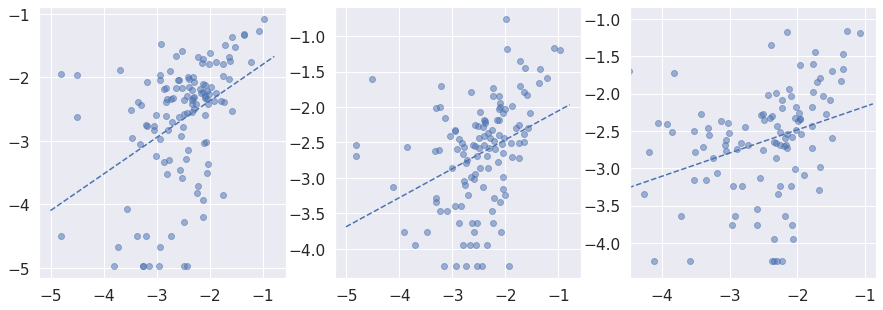

<IPython.core.display.Javascript object>

In [25]:
# Supplementary Figure 4b

puck8.total_reads = sum(puck8.s1_total_counts)
puck9.total_reads = sum(puck9.s1_total_counts)
puck10.total_reads = sum(puck10.s1_total_counts)

puck8.total_cl_counts = 0
puck9.total_cl_counts = 0
puck10.total_cl_counts = 0

puck8_umi_cl_counts = []
puck9_umi_cl_counts = []
for cl in puck8.tcr_loc_dict_s1_filtered3:
    if cl in puck9.tcr_loc_dict_s1_filtered3:
        if len(puck8.tcr_loc_dict_s1_filtered3[cl]) <= 0:
            continue
        if len(puck9.tcr_loc_dict_s1_filtered3[cl]) <= 0:
            continue
        puck8.total_cl_counts += len(puck8.tcr_loc_dict_s1_filtered3[cl])
        puck9.total_cl_counts += len(puck9.tcr_loc_dict_s1_filtered3[cl])
        puck8_umi_cl_counts.append(len(puck8.tcr_loc_dict_s1_filtered3[cl]))
        puck9_umi_cl_counts.append(len(puck9.tcr_loc_dict_s1_filtered3[cl]))

puck8_umi_cl_counts_vs10 = []
puck10_umi_cl_counts = []
for cl in puck8.tcr_loc_dict_s1_filtered3:
    if cl in puck10.tcr_loc_dict_s1_filtered3:
        if len(puck8.tcr_loc_dict_s1_filtered3[cl]) <= 0:
            continue
        if len(puck10.tcr_loc_dict_s1_filtered3[cl]) <= 0:
            continue
        puck8_umi_cl_counts_vs10.append(
            len(puck8.tcr_loc_dict_s1_filtered3[cl]))
        puck10.total_cl_counts += len(puck10.tcr_loc_dict_s1_filtered3[cl])
        puck10_umi_cl_counts.append(len(puck10.tcr_loc_dict_s1_filtered3[cl]))

puck9_umi_cl_counts_vs10 = []
puck10_umi_cl_counts_vs9 = []
for cl in puck9.tcr_loc_dict_s1_filtered3:
    if cl in puck10.tcr_loc_dict_s1_filtered3:
        if len(puck9.tcr_loc_dict_s1_filtered3[cl]) <= 0:
            continue
        if len(puck10.tcr_loc_dict_s1_filtered3[cl]) <= 0:
            continue

        puck9_umi_cl_counts_vs10.append(
            len(puck9.tcr_loc_dict_s1_filtered3[cl]))
        puck10_umi_cl_counts_vs9.append(
            len(puck10.tcr_loc_dict_s1_filtered3[cl]))

puck8_umi_cl_counts = normalize_by_total_reads(puck8_umi_cl_counts,
                                               puck8.total_cl_counts)
puck8_umi_cl_counts_vs10 = normalize_by_total_reads(puck8_umi_cl_counts_vs10,
                                                    puck8.total_cl_counts)
puck9_umi_cl_counts = normalize_by_total_reads(puck9_umi_cl_counts,
                                               puck9.total_cl_counts)
puck9_umi_cl_counts_vs10 = normalize_by_total_reads(puck9_umi_cl_counts_vs10,
                                                    puck9.total_cl_counts)
puck10_umi_cl_counts = normalize_by_total_reads(puck10_umi_cl_counts,
                                                puck10.total_cl_counts)
puck10_umi_cl_counts_vs9 = normalize_by_total_reads(puck10_umi_cl_counts_vs9,
                                                    puck10.total_cl_counts)

puck8_umi_cl_counts = np.log10(puck8_umi_cl_counts)
puck9_umi_cl_counts = np.log10(puck9_umi_cl_counts)
puck10_umi_cl_counts = np.log10(puck10_umi_cl_counts)
puck8_umi_cl_counts_vs10 = np.log10(puck8_umi_cl_counts_vs10)
puck9_umi_cl_counts_vs10 = np.log10(puck9_umi_cl_counts_vs10)
puck10_umi_cl_counts_vs9 = np.log10(puck10_umi_cl_counts_vs9)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.scatter(puck8_umi_cl_counts,
            puck9_umi_cl_counts,
            label="8 vs 9",
            alpha=0.5)
ax2.scatter(puck8_umi_cl_counts_vs10,
            puck10_umi_cl_counts,
            label="8 vs 10",
            alpha=0.5)
ax3.scatter(puck9_umi_cl_counts_vs10,
            puck10_umi_cl_counts_vs9,
            label="9 vs 10",
            alpha=0.5)
# plt.legend()

abline(
    scipy.stats.linregress(puck8_umi_cl_counts, puck9_umi_cl_counts)[0],
    scipy.stats.linregress(puck8_umi_cl_counts, puck9_umi_cl_counts)[1],
    ax_name=ax1,
)
abline(
    scipy.stats.linregress(puck8_umi_cl_counts_vs10, puck10_umi_cl_counts)[0],
    scipy.stats.linregress(puck8_umi_cl_counts_vs10, puck10_umi_cl_counts)[1],
    ax_name=ax2,
)
abline(
    scipy.stats.linregress(puck9_umi_cl_counts_vs10,
                           puck10_umi_cl_counts_vs9)[0],
    scipy.stats.linregress(puck9_umi_cl_counts_vs10,
                           puck10_umi_cl_counts_vs9)[1],
    ax_name=ax3,
)

print(
    "r",
    scipy.stats.linregress(puck8_umi_cl_counts, puck9_umi_cl_counts)[2],
    "pval",
    scipy.stats.linregress(puck8_umi_cl_counts, puck9_umi_cl_counts)[3],
)
print(
    "r",
    scipy.stats.linregress(puck8_umi_cl_counts_vs10, puck10_umi_cl_counts)[2],
    "pval",
    scipy.stats.linregress(puck8_umi_cl_counts_vs10, puck10_umi_cl_counts)[3],
)
print(
    "r",
    scipy.stats.linregress(puck9_umi_cl_counts_vs10,
                           puck10_umi_cl_counts_vs9)[2],
    "pval",
    scipy.stats.linregress(puck9_umi_cl_counts_vs10,
                           puck10_umi_cl_counts_vs9)[3],
)

args = (
    puck9_umi_cl_counts_vs10,
    puck10_umi_cl_counts_vs9,
    puck8_umi_cl_counts_vs10,
    puck10_umi_cl_counts,
    puck8_umi_cl_counts,
    puck9_umi_cl_counts,
)
all_counts = np.concatenate(args)

max_val = max(all_counts)
min_val = min(all_counts)
plt.xlim([min_val * 0.9, max_val * 1.1])
plt.ylim([min_val * 0.9, max_val * 1.1])
plt.show()

<Figure size 432x288 with 0 Axes>

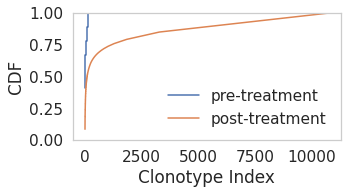

<IPython.core.display.Javascript object>

In [26]:
# Supplementary Figure 4c
# CDF for bulk
# Histogram of percent of all beads vs clonotype
plt.figure()
pre_bulk_cdf = list(pre_bulk_beta.sort_values("Freq", ascending=False).cumsum()["Freq"])
post_bulk_cdf = list(
    post_bulk_beta.sort_values("Freq", ascending=False).cumsum()["Freq"]
)
sns.set_style("whitegrid", {"axes.grid": False})

plt.figure(figsize=(5, 3))
plt.step(range(len(pre_bulk_cdf)), pre_bulk_cdf, label="pre-treatment")
plt.step(range(len(post_bulk_cdf)), post_bulk_cdf, label="post-treatment")
plt.ylim([0, 1])
plt.xlabel("Clonotype Index")
plt.ylabel("CDF")
plt.legend(frameon=False)
plt.tight_layout()

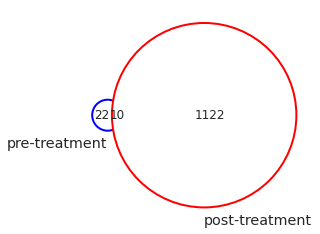

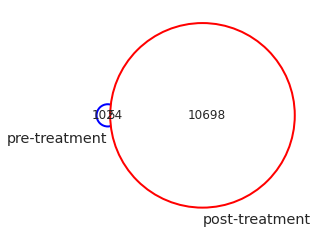

<IPython.core.display.Javascript object>

In [33]:
# Supplementary Figure 4d
pre_treatment_df = pd.read_csv(
    "{}pre_treatment_clonotype_fraction_slide_seq.csv".format(directory)
)
post_treatment_df = pd.read_csv(
    "{}post_treatment_clonotype_fraction_slide_seq.csv".format(directory)
)

clono_vd(
    list(pre_treatment_df.clonotype),
    list(post_treatment_df.clonotype),
    ("pre-treatment", "post-treatment"),
    filename="{}Supplementary Figure 5B_slide_seq.pdf".format(directory),
)
clono_vd(
    list(pre_bulk_beta.cdr3),
    list(post_bulk_beta.cdr3),
    ("pre-treatment", "post-treatment"),
    filename="{}Supplementary Figure 5B_bulk.pdf".format(directory),
)

Text(0, 0.5, 'Fraction in post-treatment')

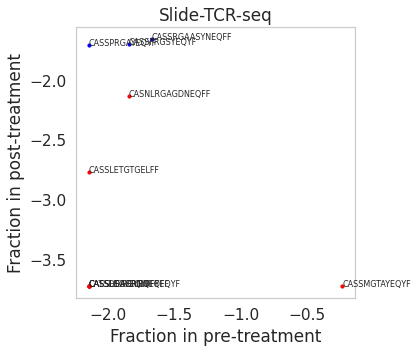

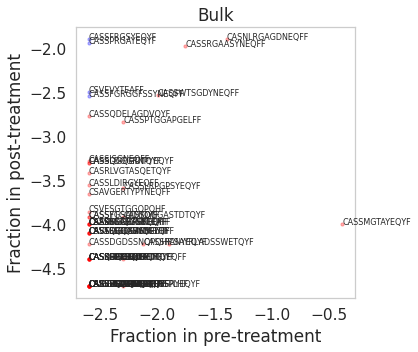

<IPython.core.display.Javascript object>

In [35]:
# Supplementary Figure 4e

plt.rcParams.update({"font.size": 8})
shared_test = list(set(pre_treatment_df.clonotype) & set(post_treatment_df.clonotype))
x = []
y = []
for i in shared_test:
    x.append(float(pre_treatment_df[pre_treatment_df.clonotype == i].fraction))
    y.append(float(post_treatment_df[post_treatment_df.clonotype == i].fraction))

x_pre_higher = []
y_pre_higher = []
x_post_higher = []
y_post_higher = []

for (xid, yid) in zip(x, y):
    if xid > yid:
        x_pre_higher.append(xid)
        y_pre_higher.append(yid)
    else:
        x_post_higher.append(xid)
        y_post_higher.append(yid)

x_pre_higher = np.log10(x_pre_higher)
y_pre_higher = np.log10(y_pre_higher)
x_post_higher = np.log10(x_post_higher)
y_post_higher = np.log10(y_post_higher)

fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(
    x_pre_higher,
    y_pre_higher,
    c="red",
    s=10,
    label="Higher clonotype fraction in pre-treatment",
)
plt.scatter(
    x_post_higher,
    y_post_higher,
    c="blue",
    s=10,
    label="Higher clonotype fraction in post-treatment",
)
plt.title("Slide-TCR-seq")
for i, txt in enumerate(shared_test):
    # ax.annotate(txt, (x[i], y[i]))
    ax.annotate(txt, (np.log10(x[i]), np.log10(y[i])))
plt.xlabel("Fraction in pre-treatment")
plt.ylabel("Fraction in post-treatment")

#### BULK
# PLOT CHANGES IN CLONOTYPE FRACTIONS FOR SHARED CLONOTYPES AND ALL CLONOTYPES for slide-seq and bulk
plt.rcParams.update({"font.size": 8})
shared_test = list(set(pre_bulk_beta.cdr3) & set(post_bulk_beta.cdr3))
x = []
y = []
for i in shared_test:
    x.append(float(pre_bulk_beta[pre_bulk_beta.cdr3 == i].Freq))
    y.append(float(post_bulk_beta[post_bulk_beta.cdr3 == i].Freq))

x_pre_higher = []
y_pre_higher = []
x_post_higher = []
y_post_higher = []

for (xid, yid) in zip(x, y):
    if xid > yid:
        x_pre_higher.append(xid)
        y_pre_higher.append(yid)
    else:
        x_post_higher.append(xid)
        y_post_higher.append(yid)

x_pre_higher = np.log10(x_pre_higher)
y_pre_higher = np.log10(y_pre_higher)
x_post_higher = np.log10(x_post_higher)
y_post_higher = np.log10(y_post_higher)

fig, ax = plt.subplots(figsize=(5, 5))
# plt.scatter(x,y)
plt.scatter(
    x_pre_higher,
    y_pre_higher,
    c="red",
    s=10,
    label="Higher clonotype fraction in pre-treatment",
    alpha=0.3,
)
plt.scatter(
    x_post_higher,
    y_post_higher,
    c="blue",
    s=10,
    label="Higher clonotype fraction in post-treatment",
    alpha=0.3,
)
plt.title("Bulk")
for i, txt in enumerate(shared_test):
    # ax.annotate(txt, (x[i], y[i]))
    ax.annotate(txt, (np.log10(x[i]), np.log10(y[i])))
plt.xlabel("Fraction in pre-treatment")
plt.ylabel("Fraction in post-treatment")

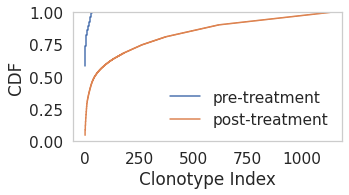

<IPython.core.display.Javascript object>

In [39]:
# Figure 2c
pre_treatment_df = pd.read_csv(
    "{}pre_treatment_clonotype_fraction_slide_seq.csv".format(directory)
)
post_treatment_df = pd.read_csv(
    "{}post_treatment_clonotype_fraction_slide_seq.csv".format(directory)
)

# Histogram of percent of all beads vs clonotype
plt.rcParams.update({"font.size": 16})

plt.figure(figsize=(5, 3))
plt.step(
    range(len(np.cumsum(pre_treatment_df.fraction))),
    np.cumsum(pre_treatment_df.fraction),
    label="pre-treatment",
)
plt.step(
    range(len(np.cumsum(post_treatment_df.fraction))),
    np.cumsum(post_treatment_df.fraction),
    label="post-treatment",
)
plt.ylim([0, 1])
plt.xlabel("Clonotype Index")
plt.ylabel("CDF")
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("./vectorized_figures/figure2e.pdf")

# Figure 2d - Compartment visualization and Supplementary Figure 6a

  0%|          | 0/3 [00:00<?, ?it/s]

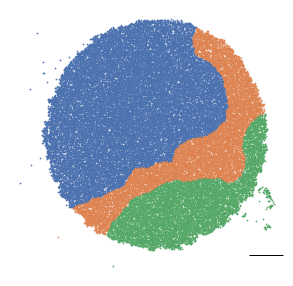

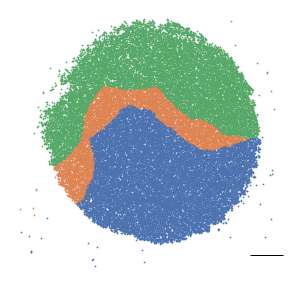

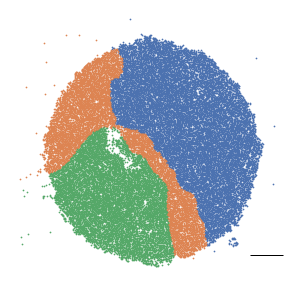

<IPython.core.display.Javascript object>

In [151]:
# Plot cell type compartments

for puck in tqdm([puck8, puck9, puck10]):
    fig, ax = plt.subplots(figsize=(5, 5))
    puck.tumor_beads = [
        i for i in puck.tll_loc_cluster_dict if puck.tll_loc_cluster_dict[i] == "Tumor"
    ]

    puck.til_beads = [
        i
        for i in puck.tll_loc_cluster_dict
        if puck.tll_loc_cluster_dict[i] == "TIL Chemokines"
    ]

    puck.lung_beads = [
        i for i in puck.tll_loc_cluster_dict if puck.tll_loc_cluster_dict[i] == "Lung"
    ]

    plt.scatter(
        [i[0] for i in puck.tumor_beads],
        [i[1] for i in puck.tumor_beads],
        label="tumor",
        s=0.5,
        alpha=1,
        color=sns.color_palette()[0],
    )
    plt.scatter(
        [i[0] for i in puck.til_beads],
        [i[1] for i in puck.til_beads],
        label="tll",
        s=0.5,
        alpha=1,
        color=sns.color_palette()[1],
    )
    plt.scatter(
        [i[0] for i in puck.lung_beads],
        [i[1] for i in puck.lung_beads],
        label="lung",
        s=0.5,
        alpha=1,
        color=sns.color_palette()[2],
    )

    plt.axis("off")
    fontprops = fm.FontProperties(size=18)
    scalebar = AnchoredSizeBar(
        ax.transData,
        pixels_needed,
        "",
        "lower right",
        pad=0.1,
        color="black",
        frameon=False,
        size_vertical=1,
        fontproperties=fontprops,
    )
    ax.add_artist(scalebar)

    plt.show()

# Figure 2e - All clonotypes and Supplementary Figure 3b

752 total number of clonotypes on this puck


  0%|          | 0/752 [00:00<?, ?it/s]

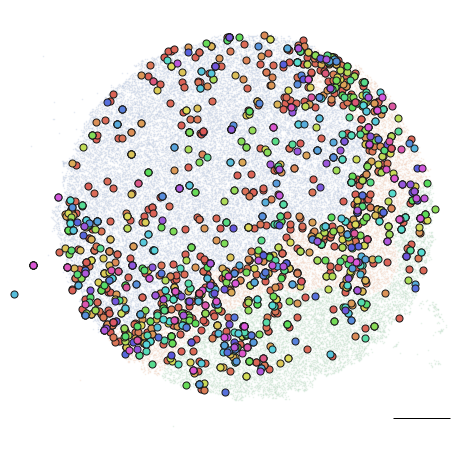

<IPython.core.display.Javascript object>

In [42]:
# Plot all clonotypes in different colors
puck = puck8

clonotypes_to_plot = []
clonotypes_to_plot_names = []
for cl in puck.tcr_loc_dict_s1_filtered3:
    if cl not in puck.clonotypes["1b"]:
        continue
    clonotypes_to_plot = clonotypes_to_plot + [cl]
    clonotypes_to_plot_names.append(cl)

print(len(clonotypes_to_plot_names), "total number of clonotypes on this puck")

fig, ax = plt.subplots(figsize=(8, 8))
t_plotx = [
    j[0]
    for j in [
        i for i in puck.tll_loc_cluster_dict if puck.tll_loc_cluster_dict[i] == "Tumor"
    ]
]
t_ploty = [
    j[1]
    for j in [
        i for i in puck.tll_loc_cluster_dict if puck.tll_loc_cluster_dict[i] == "Tumor"
    ]
]
ax.scatter(t_plotx, t_ploty, s=0.5, alpha=0.1, label="Tumor")

til_plotx = [
    j[0]
    for j in [
        i
        for i in puck.tll_loc_cluster_dict
        if puck.tll_loc_cluster_dict[i] == "TIL Chemokines"
    ]
]
til_ploty = [
    j[1]
    for j in [
        i
        for i in puck.tll_loc_cluster_dict
        if puck.tll_loc_cluster_dict[i] == "TIL Chemokines"
    ]
]
ax.scatter(til_plotx, til_ploty, s=0.5, alpha=0.1, label="Immune")

til_plotx = [
    j[0]
    for j in [
        i for i in puck.tll_loc_cluster_dict if puck.tll_loc_cluster_dict[i] == "Lung"
    ]
]
til_ploty = [
    j[1]
    for j in [
        i for i in puck.tll_loc_cluster_dict if puck.tll_loc_cluster_dict[i] == "Lung"
    ]
]
ax.scatter(til_plotx, til_ploty, s=0.5, alpha=0.1, label="Lung")

for idx in tqdm(range(len(clonotypes_to_plot))):
    clonotype = clonotypes_to_plot[idx]
    #####
    loc_for_this_cl = list(set(puck.tcr_loc_dict_s1_filtered3[clonotype]))

    x_val = [float(i[0]) for i in loc_for_this_cl]
    y_val = [float(i[1]) for i in loc_for_this_cl]

    plt.scatter(
        x_val,
        y_val,
        label=clonotype,
        color=sns.color_palette("hls", len(clonotypes_to_plot))[idx],
        edgecolors="k",
        linewidth=1,
        s=50,
    )
    plt.xlim(0, 6000)
    plt.ylim(0, 6000)

    plt.axis("off")
fontprops = fm.FontProperties(size=18)
scalebar = AnchoredSizeBar(
    ax.transData,
    pixels_needed,
    "",
    "lower right",
    pad=0.1,
    color="black",
    frameon=False,
    size_vertical=1,
    fontproperties=fontprops,
)

ax.add_artist(scalebar)
plt.show()

# Figure 2f - Spatial enrichment analysis and Supplementary Figure 6b-c 

In [43]:
# Aggregate all pucks

cl_agg_enrichment = {}
compartments = ["Tumor", "Lung", "TIL"]
for i in compartments:
    cl_agg_enrichment[i] = {}

add_cp_puck(puck8, cl_agg_enrichment)
add_cp_puck(puck9, cl_agg_enrichment)
add_cp_puck(puck10, cl_agg_enrichment)

# Take mean for each clonotype
for c in compartments:
    cl_agg_enrichment[c] = {
        i: np.mean(cl_agg_enrichment[c][i]) for i in cl_agg_enrichment[c]
    }

<IPython.core.display.Javascript object>

In [149]:
# Boundary-based distance testing
# Only look at TCR betas with at least 10 beads.
# Compare against all other beads.
analyze_tumor = True

if analyze_tumor:
    num_bins = 10
    show_plot = False
    aggregated_distribution_for_this_cl = {}
    aggregated_p_values_greater = {}
    aggregated_p_values_less = {}
    num_counts = {}
    for puck in [puck8, puck9, puck10]:
        # Try distance from boundary instead
        distance_vectors_for_cls = {}
        aggregate_distance = []
        for cl in tqdm(puck.tcr_loc_dict_s1_filtered3):
            if cl not in puck.clonotypes["1b"]:
                continue
            all_pts = list(set(puck.tcr_loc_dict_s1_filtered3[cl]))

            distance_distribution = [
                distance_between_points(pt, closest_node(pt, puck.boundary_points))
                for pt in all_pts
                if pt in puck.tumor_beads
            ]
            # if you want to include the distance not in tumor
            distance_distribution = distance_distribution + [
                -distance_between_points(pt, closest_node(pt, puck.boundary_points))
                for pt in all_pts
                if pt not in puck.tumor_beads
            ]

            if cl not in num_counts:
                num_counts[cl] = 0
            num_counts[cl] += len(all_pts)

            if len(all_pts) < 10:
                aggregate_distance = aggregate_distance + distance_distribution
                continue
            distance_vectors_for_cls[cl] = distance_distribution
            aggregate_distance = aggregate_distance + distance_distribution

        print(len(aggregate_distance))

        for cl in distance_vectors_for_cls:
            if cl not in aggregated_p_values_greater:
                aggregated_p_values_greater[cl] = []
            if cl not in aggregated_p_values_less:
                aggregated_p_values_less[cl] = []
            if bin_them is False:
                aggregate_distance_for_this_cl = copy.deepcopy(aggregate_distance)
            aggregate_distance_for_this_cl = list(aggregate_distance_for_this_cl)
            for i in distance_vectors_for_cls[cl]:  # remove clonotype you're testing
                aggregate_distance_for_this_cl.remove(i)
            aggregated_distribution_for_this_cl[cl] = aggregate_distance_for_this_cl

            if show_plot:
                plt.figure()
                plt.title(cl)
                plt.hist(
                    distance_vectors_for_cls[cl],
                    alpha=0.5,
                    density=True,
                    range=(min_val, max_val),
                    bins=20,
                )
                plt.hist(
                    aggregate_distance_for_this_cl,
                    alpha=0.5,
                    density=True,
                    range=(min_val, max_val),
                    bins=20,
                )

            min_val = min(min(distance_vectors_for_cls[cl]), min(aggregate_distance))
            max_val = max(max(distance_vectors_for_cls[cl]), max(aggregate_distance))
            aggregated_p_values_greater[cl].append(
                kstest(
                    distance_vectors_for_cls[cl],
                    aggregate_distance_for_this_cl,
                    alternative="less",
                )[1]
            )
            aggregated_p_values_less[cl].append(
                kstest(
                    distance_vectors_for_cls[cl],
                    aggregate_distance_for_this_cl,
                    alternative="greater",
                )[1]
            )
            print(
                cl,
                kstest(
                    distance_vectors_for_cls[cl],
                    aggregate_distance_for_this_cl,
                    alternative="less",
                )[1],
            )
            print(
                cl,
                ttest_ind(distance_vectors_for_cls[cl], aggregate_distance_for_this_cl)[
                    1
                ],
            )

  0%|          | 0/1010 [00:00<?, ?it/s]

1761
CSARDPGPDTQYF 0.8407993001839068
CSARDPGPDTQYF 0.3569230711653888
CASSQGLAGVLGQFF 0.3063830126216708
CASSQGLAGVLGQFF 0.2686590269084625
CASSPRTSGRYNEQFF 0.0006120245469546074
CASSPRTSGRYNEQFF 0.09314816391141119
CASSVTGETGELFF 0.22144329220562586
CASSVTGETGELFF 0.827169978444138
CASRVQGGPGANVLTF 0.19360935769667387
CASRVQGGPGANVLTF 0.556276536890693
CASSPYHSSGGETQYF 0.010179578576849464
CASSPYHSSGGETQYF 0.013072545927226897
CASSPTVYNEQFF 0.034120603107774455
CASSPTVYNEQFF 0.04608769390978417
CASSPRGAYEQYF 0.14052187695609056
CASSPRGAYEQYF 0.20847719195441627
CASSFRGSYEQYF 0.36714432893596616
CASSFRGSYEQYF 0.8394407855709373
CASSRGAASYNEQFF 0.7800227257833072
CASSRGAASYNEQFF 0.3884229621340879
CASRQGNTEAFF 0.08112073348236522
CASRQGNTEAFF 0.15498677605663347
CASRGQGGYNSPLHF 0.9126827159749202
CASRGQGGYNSPLHF 0.22263498579799026
CASRGAHSNQPQHF 0.33238798267295006
CASRGAHSNQPQHF 0.40475269329939634
CASSSSDRGYQETQYF 0.6732074695314133
CASSSSDRGYQETQYF 0.035087319423020506
CSASVYGPSYEQ

  0%|          | 0/1020 [00:00<?, ?it/s]

2147
CSARDPGPDTQYF 0.2540569365406998
CSARDPGPDTQYF 0.9998665067939083
CASSPRTSGRYNEQFF 0.7621161710462272
CASSPRTSGRYNEQFF 0.6112259455200137
CASSQGLAGVLGQFF 0.7801480166505798
CASSQGLAGVLGQFF 0.8363727532569213
CASRVQGGPGANVLTF 0.06637640553143469
CASRVQGGPGANVLTF 0.3937087348829811
CASSPTVYNEQFF 0.02829508751411702
CASSPTVYNEQFF 0.05802966594880265
CASSVAVLNTEAFF 0.06920487255178032
CASSVAVLNTEAFF 0.009164658722851871
CASSPRGAYEQYF 0.01878882616223126
CASSPRGAYEQYF 0.02481738646693174
CASSFRGSYEQYF 0.12279216859405663
CASSFRGSYEQYF 0.7639334835472105
CASSPYHSSGGETQYF 0.1283849471012859
CASSPYHSSGGETQYF 0.2927420796137528
CASSDWAGSTDTQYF 0.3882069152744363
CASSDWAGSTDTQYF 0.13496681361265875
CASSRGAASYNEQFF 0.6507933252026775
CASSRGAASYNEQFF 0.48462576595430684
CASSVTGETGELFF 0.029065672499032653
CASSVTGETGELFF 0.028112685444861986
CASSTTGGIHEQFF 0.8327223935098603
CASSTTGGIHEQFF 0.02995017024951557
CASSPTGGAPGELFF 0.6783944041192531
CASSPTGGAPGELFF 0.7607744927025967
CASSLSRTGGAGGTD

  0%|          | 0/673 [00:00<?, ?it/s]

1386
CASSQGLAGVLGQFF 0.15113887669719064
CASSQGLAGVLGQFF 0.4279173808051051
CSARDPGPDTQYF 0.9876067117960985
CSARDPGPDTQYF 0.02961972084040908
CASSPRTSGRYNEQFF 0.04952455357046645
CASSPRTSGRYNEQFF 0.20446026531410808
CASSRGAASYNEQFF 0.9750630572664333
CASSRGAASYNEQFF 0.0121764766001829
CASSVTGETGELFF 0.17582687000939573
CASSVTGETGELFF 0.6642180045014765
CASSPYHSSGGETQYF 0.02631245542450825
CASSPYHSSGGETQYF 0.44916667178651626
CASRVQGGPGANVLTF 0.14866687128864448
CASRVQGGPGANVLTF 0.14098104348693438
CSARDPAQGITGELFF 0.4559366009911078
CSARDPAQGITGELFF 0.7641027315733461
CASSPTVYNEQFF 0.6852421784246354
CASSPTVYNEQFF 0.6499975685544725
CASMRDRGKGYNEQFF 0.02226795945835781
CASMRDRGKGYNEQFF 0.051739687728941226
CASSPRGAYEQYF 0.43700958425753816
CASSPRGAYEQYF 0.8836906708355468
CASSSSLGLAGANEQFF 0.45295464768705423
CASSSSLGLAGANEQFF 0.9797807075191038
CASSFRGSYEQYF 0.24765914018003096
CASSFRGSYEQYF 0.70246824625502
CASSLLASSYEQYF 0.22251683333001776
CASSLLASSYEQYF 0.07331418075259437
CASRGA

<IPython.core.display.Javascript object>

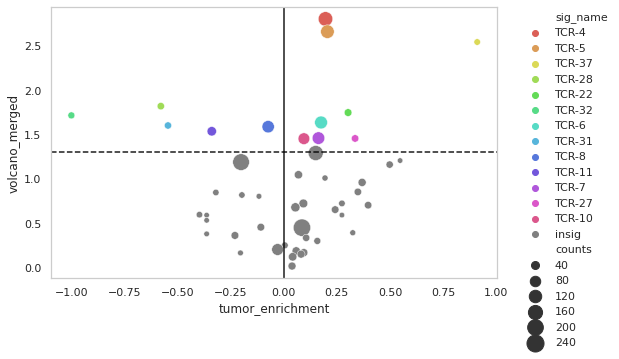

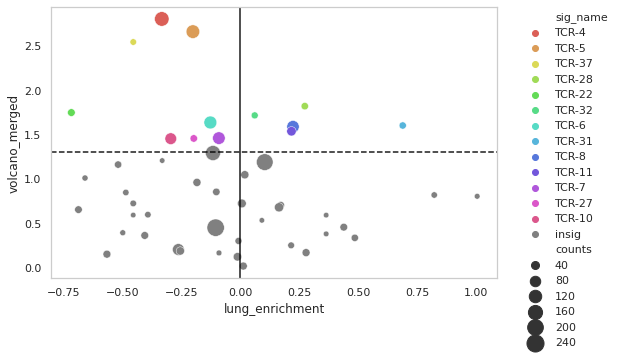

<IPython.core.display.Javascript object>

In [150]:
# Make plot
aggregated_p_values_greater_adj = {}
aggregated_p_values_less_adj = {}
cls_to_look_at = list(aggregated_p_values_greater.keys())
for cl in cls_to_look_at:
    aggregated_p_values_greater_adj[cl] = scipy.stats.combine_pvalues(
        aggregated_p_values_greater[cl]
    )[1]
    aggregated_p_values_less_adj[cl] = scipy.stats.combine_pvalues(
        aggregated_p_values_less[cl]
    )[1]

# Adjust p values
all_p_vals = list(aggregated_p_values_greater_adj.values())

pvalue_greater = [
    -np.log10(aggregated_p_values_greater_adj[cl]) for cl in cls_to_look_at
]
pvalue_greater_adjusted = [
    -np.log10(i)
    for i in statsmodels.stats.multitest.multipletests(all_p_vals, method="fdr_bh")[1]
]

pvalue_less = [-np.log10(aggregated_p_values_less_adj[cl]) for cl in cls_to_look_at]
pvalue_less_adjusted = [
    -np.log10(i)
    for i in statsmodels.stats.multitest.multipletests(
        list(aggregated_p_values_less_adj.values()), method="fdr_bh"
    )[1]
]

dict_plot = {
    "clonotype": cls_to_look_at,
    "tumor_enrichment": [cl_agg_enrichment["Tumor"][cl] for cl in cls_to_look_at],
    "lung_enrichment": [cl_agg_enrichment["Lung"][cl] for cl in cls_to_look_at],
    "pvalue_greater": pvalue_greater,
    "pvalue_greater_adjusted": pvalue_greater_adjusted,
    "pvalue_less": pvalue_less,
    "pvalue_less_adjusted": pvalue_less_adjusted,
    "counts": [num_counts[cl] for cl in cls_to_look_at],
}

plot_df = pd.DataFrame.from_dict(dict_plot)
plot_df.reset_index(drop=True, inplace=True)

pvalue_to_use_greater = "pvalue_greater"
pvalue_to_use_less = "pvalue_less"

pvalue_to_use_greater = "pvalue_greater"
pvalue_to_use_less = "pvalue_less"

## MAKE VOLCANO MERGED COLUMN
volcano_merged = []
for index, row in plot_df.iterrows():
    if row["tumor_enrichment"] < 0:
        volcano_merged.append(row[pvalue_to_use_less])
    elif row["tumor_enrichment"] > 0:
        volcano_merged.append(row[pvalue_to_use_greater])
    else:
        print("we have a zero over here!")
plot_df["volcano_merged"] = volcano_merged
###
plot_df["clonotype"] = [pretty_clonotype_name[i] for i in plot_df["clonotype"]]

plot_df["sig_name"] = [
    plot_df.clonotype[idx]
    if (
        (plot_df[pvalue_to_use_greater][idx] > -np.log10(0.05))
        or (plot_df[pvalue_to_use_less][idx] > -np.log10(0.05))
    )
    else "insig"
    for idx in range(len(plot_df.clonotype))
]
plot_df["sig_name_greater"] = [
    plot_df.clonotype[idx]
    if (plot_df[pvalue_to_use_greater][idx] > -np.log10(0.05))
    else "insig"
    for idx in range(len(plot_df.clonotype))
]

y_metric = "volcano_merged"
hue_metric = "sig_name"

plot_df.sort_values("volcano_merged", inplace=True, ascending=False)
plt.rcParams.update({"font.size": 20})
colors_to_use = sns.color_palette("hls", len(set(plot_df[hue_metric])) - 1) + ["gray"]

fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(
    data=plot_df,
    x="tumor_enrichment",
    y=y_metric,
    hue=hue_metric,
    palette=colors_to_use,
    sizes=(30, 300),
    size="counts",
)  # volcano_merged
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.0, frameon=False)
ax.axvline(0, c="black", alpha=0.9)
ax.axhline(-np.log10(0.05), c="black", alpha=0.9, linestyle="--")

fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(
    data=plot_df,
    x="lung_enrichment",
    y=y_metric,
    hue=hue_metric,
    palette=colors_to_use,
    sizes=(30, 300),
    size="counts",
)  # volcano_merged
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.0, frameon=False)
ax.axvline(0, c="black", alpha=0.9)
ax.axhline(-np.log10(0.05), c="black", alpha=0.9, linestyle="--")

  0%|          | 0/3 [00:00<?, ?it/s]

CASSPRTSGRYNEQFF 0
CASSPYHSSGGETQYF 1
CASSRGAASYNEQFF 8
CASSTTGGIHEQFF 9
CASSPRTSGRYNEQFF 0
CASSPYHSSGGETQYF 1
CASSRGAASYNEQFF 8
CASSTTGGIHEQFF 9
CASSPRTSGRYNEQFF 0
CASSPYHSSGGETQYF 1
CASSRGAASYNEQFF 8
CASSTTGGIHEQFF 9


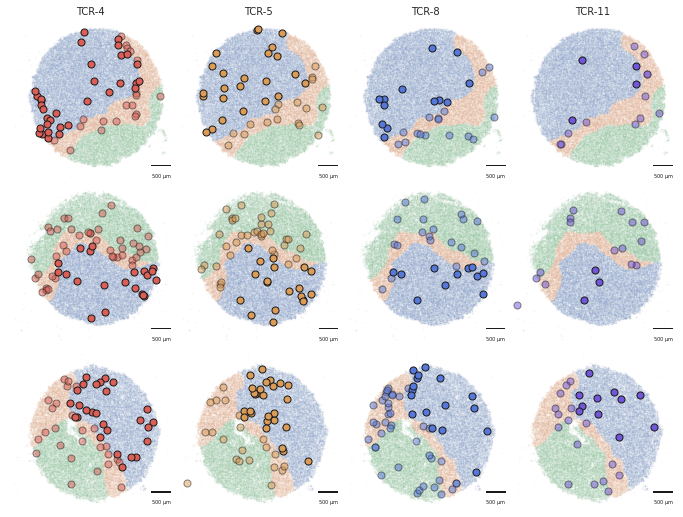

<IPython.core.display.Javascript object>

In [147]:
# plot significant clonotypes on all pucks

plot_df[(plot_df.tumor_enrichment < 0) & (plot_df.volcano_merged > -np.log10(0.05))]

significant_clonotypes = [
    ugly_clonotype_name[i] for i in list(plot_df.sig_name) if i != "insig"
]

test = [4, 5, 8, 11]
tcr_name = ["TCR-" + str(i) for i in test]
plotting_clonotypes = [
    i for i in pretty_clonotype_name if pretty_clonotype_name[i] in tcr_name
]

plt.rcParams.update({"font.size": 22})
fig, ax = plt.subplots(
    3, len(plotting_clonotypes), figsize=(3 * len(plotting_clonotypes), 9)
)

for puck in tqdm([puck8, puck9, puck10]):  # puck8,puck9,

    if puck == puck8:
        loc_x = 0
    elif puck == puck9:
        loc_x = 1
    else:
        loc_x = 2
    for cl in plotting_clonotypes:

        puck.tumor_beads = [
            i
            for i in puck.tll_loc_cluster_dict
            if puck.tll_loc_cluster_dict[i] == "Tumor"
        ]

        puck.til_beads = [
            i
            for i in puck.tll_loc_cluster_dict
            if puck.tll_loc_cluster_dict[i] == "TIL Chemokines"
        ]

        puck.lung_beads = [
            i
            for i in puck.tll_loc_cluster_dict
            if puck.tll_loc_cluster_dict[i] == "Lung"
        ]

        ax[loc_x, plotting_clonotypes.index(cl)].scatter(
            [i[0] for i in puck.til_beads],
            [i[1] for i in puck.til_beads],
            label="tll",
            s=0.5,
            alpha=0.05,
            color=sns.color_palette()[1],
        )
        ax[loc_x, plotting_clonotypes.index(cl)].scatter(
            [i[0] for i in puck.lung_beads],
            [i[1] for i in puck.lung_beads],
            label="lung",
            s=0.5,
            alpha=0.05,
            color=sns.color_palette()[2],
        )
        ax[loc_x, plotting_clonotypes.index(cl)].scatter(
            [i[0] for i in puck.tumor_beads],
            [i[1] for i in puck.tumor_beads],
            label="tumor",
            s=0.5,
            alpha=0.05,
            color=sns.color_palette()[0],
        )

        color_index = significant_clonotypes.index(cl)
        print(cl, color_index)
        ax[loc_x, plotting_clonotypes.index(cl)].scatter(
            [
                i[0]
                for i in set(puck.tcr_loc_dict_s1_filtered3[cl])
                if i not in puck.tumor_beads
            ],
            [
                i[1]
                for i in set(puck.tcr_loc_dict_s1_filtered3[cl])
                if i not in puck.tumor_beads
            ],
            color=sns.color_palette("hls", len(significant_clonotypes))[color_index],
            s=50,
            edgecolors="k",
            alpha=0.5,
        )
        ax[loc_x, plotting_clonotypes.index(cl)].scatter(
            [
                i[0]
                for i in set(puck.tcr_loc_dict_s1_filtered3[cl])
                if i in puck.tumor_beads
            ],
            [
                i[1]
                for i in set(puck.tcr_loc_dict_s1_filtered3[cl])
                if i in puck.tumor_beads
            ],
            color=sns.color_palette("hls", len(significant_clonotypes))[color_index],
            s=50,
            edgecolors="k",
        )

        ax[loc_x, plotting_clonotypes.index(cl)].axis("off")
        plt.rcParams.update({"font.size": 5})
        scalebar = ScaleBar(
            0.65,
            "um",
            length_fraction=1 / 3 / 2,
            frameon=False,
            label_loc="bottom",
            label=None,
            location="lower right",
        )
        ax[loc_x, plotting_clonotypes.index(cl)].add_artist(scalebar)

for ax, col in zip(ax[0], plotting_clonotypes):
    ax.set_title(pretty_clonotype_name[col], fontsize=10)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# Figure 2g-h

weird, postbeta, post alpha
CASSPLTFTDTQYF


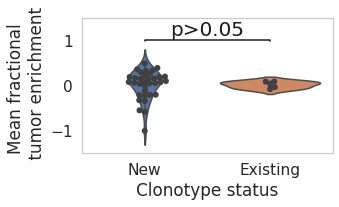

5
34


<IPython.core.display.Javascript object>

In [50]:
# Figure 2g
in_post_not_pre = []
in_both = []
in_pre_not_post = []
not_in_any = []
all_cls = list(
    set(
        list(
            [
                i
                for i in puck8.tcr_loc_dict_s1_filtered3
                if len(set(puck8.tcr_loc_dict_s1_filtered3[i])) > 10
            ]
        )
        + list(
            [
                i
                for i in puck9.tcr_loc_dict_s1_filtered3
                if len(set(puck9.tcr_loc_dict_s1_filtered3[i])) > 10
            ]
        )
        + list(
            [
                i
                for i in puck10.tcr_loc_dict_s1_filtered3
                if len(set(puck10.tcr_loc_dict_s1_filtered3[i])) > 10
            ]
        )
    )
)
for cl in all_cls:
    pre_beta = False
    pre_alpha = False
    post_beta = False
    post_alpha = False
    if cl in list(pre_bulk_beta.cdr3):
        pre_beta = True
    if cl in list(pre_bulk_alpha.cdr3):
        pre_alpha = True
    if cl in list(post_bulk_alpha.cdr3):
        post_alpha = True
    if cl in list(post_bulk_beta.cdr3):
        post_beta = True

    if pre_beta and pre_alpha:
        print("weird, prebeta and prealpha")
    if pre_beta and post_alpha:
        print("weird, prebeta and postalpha")
    if post_beta and pre_alpha:
        print("weird, postbeta, prealpha")
    if post_beta and post_alpha:
        print("weird, postbeta, post alpha")
        print(cl)
        continue
    if pre_beta and post_beta:
        # print('Present in both')
        in_both.append(cl)
    if pre_beta and not post_beta:
        # print('in pre but not in post')
        in_pre_not_post.append(cl)
    if post_beta and not pre_beta:
        # print('in post but not in pre')
        in_post_not_pre.append(cl)
    if pre_alpha or post_alpha:
        pass
    if not pre_beta and not pre_alpha and not post_beta and not post_alpha:
        not_in_any.append(cl)

tumor_enrichment_in_both = []
tumor_enrichment_in_post_not_pre = []

for cl in plot_df.clonotype:
    if ugly_clonotype_name[cl] in in_both:
        tumor_enrichment_in_both.append(
            float(plot_df[plot_df.clonotype == cl].tumor_enrichment)
        )
    if ugly_clonotype_name[cl] in in_post_not_pre:
        tumor_enrichment_in_post_not_pre.append(
            float(plot_df[plot_df.clonotype == cl].tumor_enrichment)
        )

plt.rcParams.update({"font.size": 16})
plt.figure(figsize=(5, 3))
status = ["New"] * len(tumor_enrichment_in_post_not_pre) + ["Existing"] * len(
    tumor_enrichment_in_both
)
value = tumor_enrichment_in_post_not_pre + tumor_enrichment_in_both
enrichment_vs_cl_status_df = pd.DataFrame.from_dict(
    {"status": status, "tumor_enrichment": value}
)
sns.violinplot(x="status", y="tumor_enrichment", data=enrichment_vs_cl_status_df)
sns.swarmplot(
    x="status",
    y="tumor_enrichment",
    data=enrichment_vs_cl_status_df,
    color=".25",
    size=6,
)

# statistical annotation
x1, x2 = 0, 1  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = enrichment_vs_cl_status_df["tumor_enrichment"].max() + 0.1, 0.03, "k"
y = y + 0.4
plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
plt.text((x1 + x2) * 0.5, y + h, "p>0.05", ha="center", va="bottom", color=col, size=20)
plt.ylim(-1.5, 1.5)
plt.xlabel("Clonotype status")
plt.ylabel("Mean fractional \n tumor enrichment")
plt.tight_layout()
plt.show()

print(len(enrichment_vs_cl_status_df[enrichment_vs_cl_status_df.status == "Existing"]))
print(len(enrichment_vs_cl_status_df[enrichment_vs_cl_status_df.status == "New"]))

r 0.2883349936638591 pval 0.057687102540793234
LinregressResult(slope=0.19903963291004179, intercept=0.49470464241390005, rvalue=0.2883349936638591, pvalue=0.057687102540793234, stderr=0.10199286012106866)


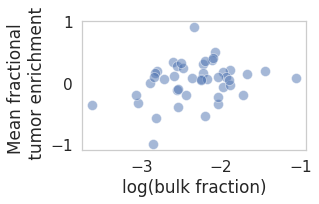

<IPython.core.display.Javascript object>

In [51]:
# Clonotype enrichment vs percentage of bulk
post_bulk_beta_filt = post_bulk_beta[post_bulk_beta.count_sum > 10]

cl_to_freq_dict = dict(
    zip(list(post_bulk_beta_filt.cdr3), list(post_bulk_beta_filt.Freq))
)

pretty_cl_to_freq = [
    pretty_clonotype_name[i] for i in cl_to_freq_dict if i in pretty_clonotype_name
]
plot_df = plot_df[plot_df.clonotype.isin(pretty_cl_to_freq)]

freq = []

tumor_enrichment = list(plot_df.tumor_enrichment)
freq = [cl_to_freq_dict[ugly_clonotype_name[cl]] for cl in list(plot_df.clonotype)]
log_freq = [np.log10(i) for i in freq]
plotting_df = pd.DataFrame.from_dict({"tumor": tumor_enrichment, "log_freq": log_freq})
plt.figure(figsize=(5, 3))
sns.scatterplot(x="log_freq", y="tumor", data=plotting_df, s=100, alpha=0.5)
plt.ylabel("Mean fractional \n tumor enrichment")
plt.xlabel("log(bulk fraction)")
print(
    "r",
    scipy.stats.linregress(log_freq, tumor_enrichment)[2],
    "pval",
    scipy.stats.linregress(log_freq, tumor_enrichment)[3],
)
print(scipy.stats.linregress(log_freq, tumor_enrichment))
plt.tight_layout()

# Figure 3b-d


In [141]:
# Load in genes
d = 50  # distance in microns
d = d / 0.65

# Load in genesets
puck = puck8
load_genesets = True
# Read in gene sets
if load_genesets:
    gene_df = pd.read_excel(
        "{}Supplementary Table 3.xls".format(directory), sheet_name="All genes"
    )
    gene_groups = {}
    for name in gene_df.columns:
        gene_groups[name] = [i for i in list(gene_df[name]) if isinstance(i, str)]
    ss_genes = puck.s1_dge_fmtd.columns

    missing_genes = []
    for group in gene_groups:
        for gene in gene_groups[group]:
            if gene in ss_genes:
                pass
            if gene not in ss_genes:
                missing_genes.append(gene)
    if len(missing_genes) > 0:
        print("These genes are missing:", missing_genes)
    # Remove missing genes
    for group in gene_groups:
        gene_groups[group] = [i for i in gene_groups[group] if i not in missing_genes]

These genes are missing: ['MS4A4C', 'CTLA2A', 'RPS17', 'MT-CYTB', 'RPL10-PS3', 'GM8730', 'GM10073', '2900026A02RIK', 'AW112010', 'SERPINA3G', 'FASL', 'IFI47', 'IZUMO1R', 'LSP1', 'CRIP1', 'NDUFB8', 'PSMA1', 'REREP3', 'OVCA2', 'CKS1B', 'ABCB1A', 'ABCB1B', 'LY6A', 'TCL1', 'NANOG', 'HAND1', 'C11ORF31', 'C11ORF48', 'C11ORF58', 'C12ORF57', 'C12ORF75', 'C14ORF166', 'C14ORF2', 'C16ORF13', 'C17ORF49', 'C17ORF62', 'C18ORF32', 'C19ORF10', 'C19ORF24', 'C19ORF53', 'C19ORF66', 'C1ORF43', 'C21ORF33', 'C2ORF68', 'C4ORF3', 'C5ORF56', 'C7ORF55-LUC7L2', 'C7ORF73', 'C9ORF16', 'EIF3CL', 'LSP1', 'NDUFB8', 'PNRC2', 'PSMA1', 'PSMA2', 'RNASEK-C17ORF49', 'SDHD', 'SLX1A', 'SLX1B', 'SRSF10', 'TMBIM4', 'TOMM6', 'UQCR11', 'IFNA2', 'IFNB1', 'IFNZ', 'OAS1A', 'OAS1B', 'TAP2', 'TAP', 'CD39', 'CD137', 'IFNA1', 'IL2']


<IPython.core.display.Javascript object>

  0%|          | 0/1010 [00:00<?, ?it/s]

ks_test KstestResult(statistic=0.28378378378378377, pvalue=6.652184340045097e-11)


/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

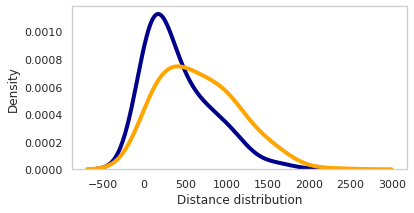

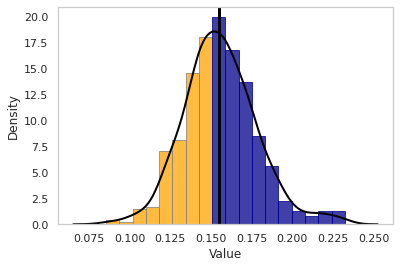

<Figure size 432x288 with 0 Axes>

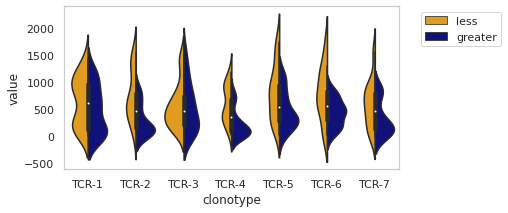

<IPython.core.display.Javascript object>

In [146]:
# Split the plots by clonotype:
# Calculate gene expression for each gene group for clonotypes separately and then all together
sns.set_style("whitegrid", {"axes.grid": False})
group = "Bad response to ICP (from Sade-Feldman et al. 2018)"

# INDIVIDUAL CLONOTYPE ANALYSIS
gene_group_cl = {}
gene_group_cl_less = {}
gene_group_cl_greater = {}
all_cl_bcs = []
for clonotype in tqdm(puck.tcr_loc_dict_s1_filtered3):
    cl_locs = [
        i
        for i in set(puck.tcr_loc_dict_s1_filtered3[clonotype])
        if i in puck.tumor_beads
    ]
    cl_bcs = [puck.loc_to_bc_s1[i] for i in cl_locs]
    all_cl_bcs = all_cl_bcs + cl_bcs
    if len(cl_bcs) < 10:
        continue

    gene_group_cl[clonotype] = list(
        puck.s1_dge_fmtd_norm.loc[cl_bcs, gene_groups[group]].sum(axis=1)
    )

    cutoff = np.median(gene_group_cl[clonotype])
    gene_group_cl_less[clonotype] = [
        cl_locs[idx]
        for idx in range(len(gene_group_cl[clonotype]))
        if gene_group_cl[clonotype][idx] < cutoff
    ]
    gene_group_cl_greater[clonotype] = [
        cl_locs[idx]
        for idx in range(len(gene_group_cl[clonotype]))
        if gene_group_cl[clonotype][idx] >= cutoff
    ]

# AGGREGATE CLONOTYPE ANALYSIS
gene_group_cl_agg = []
gene_group_cl_agg_less = []
gene_group_cl_agg_greater = []

all_cl_bcs = list(set(all_cl_bcs))
all_locs = [puck.bc_loc_dict_s1[i] for i in all_cl_bcs]

gene_group_cl_agg = list(
    puck.s1_dge_fmtd_norm.loc[all_cl_bcs, gene_groups[group]].sum(axis=1)
)
cutoff = np.median(gene_group_cl_agg)
gene_group_cl_agg_less = [
    all_locs[idx]
    for idx in range(len(gene_group_cl_agg))
    if gene_group_cl_agg[idx] < cutoff
]
gene_group_cl_agg_greater = [
    all_locs[idx]
    for idx in range(len(gene_group_cl_agg))
    if gene_group_cl_agg[idx] >= cutoff
]
less_agg_dist = [
    distance_between_points(pt, closest_node(pt, puck.boundary_points))
    for pt in gene_group_cl_agg_less
    if pt in puck.tumor_beads
]
greater_agg_dist = [
    distance_between_points(pt, closest_node(pt, puck.boundary_points))
    for pt in gene_group_cl_agg_greater
    if pt in puck.tumor_beads
]

# PLOT
plt.figure(figsize=(6, 3))
df_greater = pd.DataFrame.from_dict(
    {"Distance distribution": [i * 0.65 for i in greater_agg_dist]}
)
df_less = pd.DataFrame.from_dict(
    {"Distance distribution": [i * 0.65 for i in less_agg_dist]}
)
sns.distplot(
    df_greater["Distance distribution"],
    hist=False,
    kde=True,
    bins=int(180 / 5),
    color="darkblue",
    hist_kws={"edgecolor": "gray", "alpha": 0.75},
    kde_kws={"linewidth": 4, "bw": 0.5, "alpha": 0.75},
    norm_hist=True,
    label="Greater",
)

sns.distplot(
    df_less["Distance distribution"],
    hist=False,
    kde=True,
    bins=int(180 / 5),
    color="orange",
    hist_kws={"edgecolor": "gray", "alpha": 0.75},
    kde_kws={"linewidth": 4, "bw": 0.5, "alpha": 0.75},
    norm_hist=True,
    label="Less",
)

print(
    "ks_test",
    kstest([i * 0.65 for i in greater_agg_dist], [i * 0.65 for i in less_agg_dist]),
)

# PLOT 2
fig, ax = plt.subplots()
agg = copy.deepcopy(gene_group_cl_agg)

df_all = pd.DataFrame.from_dict({"Value": agg})

sns.distplot(
    df_all["Value"],
    hist=False,
    kde=True,
    bins=int(180 / 10),
    color="black",
    hist_kws={"edgecolor": "gray", "alpha": 0.75},
    kde_kws={"linewidth": 2, "bw": 0.3, "alpha": 0.75},
    norm_hist=True,
    label="Less",
)
plt.axvline(x=cutoff, c="black", linewidth=3)

sns.distplot(
    df_all["Value"],
    hist=True,
    kde=False,
    bins=int(180 / 10),
    color="orange",
    hist_kws={"edgecolor": "gray", "alpha": 0.75},
    kde_kws={"linewidth": 2, "bw": 0.3, "alpha": 0.75},
    norm_hist=True,
    label="Less",
)
plt.axvline(x=cutoff, c="black", linewidth=3)

for p in ax.patches:
    if p.get_xy()[0] >= cutoff * 0.95:
        p.set_color("darkblue")
    if p.get_xy()[1] >= cutoff:
        p.set_color("darkblue")

all_pvals = []

plotting_df = {}
plotting_df["less_or_greater"] = []
plotting_df["value"] = []
plotting_df["clonotype"] = []

for cl in gene_group_cl:
    less = gene_group_cl_less[cl]
    greater = gene_group_cl_greater[cl]

    less_dist = [
        distance_between_points(pt, closest_node(pt, puck.boundary_points))
        for pt in less
        if pt in puck.tumor_beads
    ]
    greater_dist = [
        distance_between_points(pt, closest_node(pt, puck.boundary_points))
        for pt in greater
        if pt in puck.tumor_beads
    ]

    if len(less_dist) < 10:
        continue
    if len(greater_dist) < 10:
        continue

    pval = round(kstest(less_dist, greater_dist)[1], 2)
    all_pvals.append(kstest(less_dist, greater_dist)[1])
    #     plt.title(cl + ' ' +  str(pval))

    plotting_df["clonotype"] = plotting_df["clonotype"] + [cl] * (
        len(less_dist) + len(greater_dist)
    )
    plotting_df["value"] = plotting_df["value"] + less_dist + greater_dist
    plotting_df["less_or_greater"] = (
        plotting_df["less_or_greater"]
        + ["less"] * len(less_dist)
        + ["greater"] * len(greater_dist)
    )

plotting_df["value"] = [i * 0.65 for i in plotting_df["value"]]

color_palette_to_use = ["orange", "darkblue"]
plotting_df = pd.DataFrame(plotting_df)
plotting_df.clonotype = [pretty_clonotype_name[i] for i in plotting_df.clonotype]
plt.figure()
plt.rcParams.update({"font.size": 10})
plotting_df.sort_values("clonotype", inplace=True)
plt.figure(figsize=(6, 3))
plotting_df.sort_values("less_or_greater", inplace=True, ascending=True)
plotting_df.sort_values("clonotype", inplace=True)
sns.violinplot(
    x="clonotype",
    y="value",
    hue="less_or_greater",
    hue_order=["less", "greater"],
    data=plotting_df,
    palette=color_palette_to_use,
    split=True,
    bw=0.5,
)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

In [145]:
# Adjust p values for above plot
p_values_all_corrected = stats.multitest.multipletests(
    all_pvals, alpha=0.05, method="fdr_bh", is_sorted=False, returnsorted=False
)
conversion_dict = dict(zip(all_pvals, p_values_all_corrected[1]))
print(conversion_dict)

{0.012632974878229897: 0.04421541207380464, 0.3380910053357701: 0.39443950622506513, 0.0013185635064001389: 0.009229944544800972, 0.10849595955262925: 0.1898679292171012, 0.9522562797299043: 0.9522562797299043, 0.2557751845677543: 0.358085258394856, 0.0746606334841629: 0.1742081447963801}


<IPython.core.display.Javascript object>

  0%|          | 0/1 [00:00<?, ?it/s]

/home/unix/sophliu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


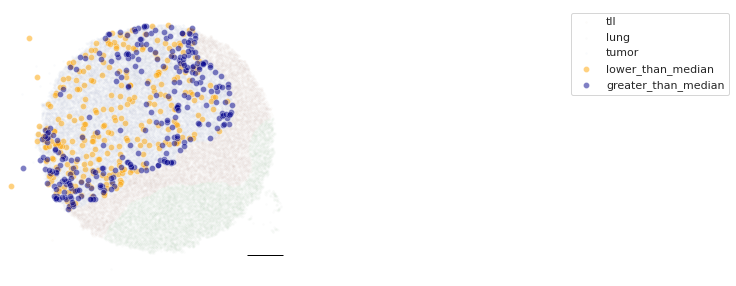

<IPython.core.display.Javascript object>

In [144]:
# Plot geneset expression spatially on puck separated by median geneset expression

# plot significant clonotypes on all pucks
plt.rcParams.update({'font.size': 10})

for puck in tqdm([puck8]):
    fig, ax = plt.subplots(figsize=(5, 5))
    puck.tumor_beads = [
            i for i in puck.tll_loc_cluster_dict
            if puck.tll_loc_cluster_dict[i] == 'Tumor'
        ]
    
    puck.til_beads = [
            i for i in puck.tll_loc_cluster_dict
            if puck.tll_loc_cluster_dict[i] == 'TIL Chemokines'
        ]
    
    puck.lung_beads = [
            i for i in puck.tll_loc_cluster_dict
            if puck.tll_loc_cluster_dict[i] == 'Lung'
        ]
    

    plt.scatter([i[0] for i in puck.til_beads],
                [i[1] for i in puck.til_beads],
                label='tll',
                s=3,
                alpha=0.01,
                color=sns.color_palette()[1])
    plt.scatter([i[0] for i in puck.lung_beads],
                [i[1] for i in puck.lung_beads],
                label='lung',
                s=3,
                alpha=0.01,
                color=sns.color_palette()[2])
    plt.scatter([i[0] for i in puck.tumor_beads],
                [i[1] for i in puck.tumor_beads],
                label='tumor',
                s=3,
                alpha=0.01,
                color=sns.color_palette()[0])

    coloring_for_each_loc = gene_group_cl_agg

    #         x = [i[0] for i in all_tcr_locs  if i in puck.tumor_beads] #
    #         y = [i[1] for i in all_tcr_locs  if i in puck.tumor_beads] #
    x = [i[0] for i in all_locs]  #
    y = [i[1] for i in all_locs]  #
    ge = coloring_for_each_loc
    plotting_df = pd.DataFrame.from_dict({'x': x, 'y': y, 'ge': ge})
    cutoff = np.median(plotting_df['ge'])  ## FOR AGGREGATE

    plotting_df_less = plotting_df[plotting_df['ge'] < cutoff]
    plotting_df_greater = plotting_df[plotting_df['ge'] >= cutoff]
    #         sns.scatterplot(data = plotting_df, x= x, y = y, hue = 'blue',alpha=0.5)

    ### FOR ORIGINAL SEPARATED PLOTS
    sns.scatterplot(data=plotting_df_less,
                    x='x',
                    y='y',
                    color='orange',
                    alpha=0.5,
                    label='lower_than_median')
    sns.scatterplot(data=plotting_df_greater,
                    x='x',
                    y='y',
                    color='darkblue',
                    alpha=0.5,
                    label='greater_than_median')
    ### FOR PLOTS COLORED BY EXPRESSION
    #         sns.scatterplot(data = plotting_df, x= 'x', y = 'y', hue='ge',alpha=0.5)
    plt.xlim([0, 6000])
    plt.ylim([0, 6000])
    ax.set_xlim([0, 6000])
    ax.set_ylim([0, 6000])
    #plt.title(group)
    plt.legend(bbox_to_anchor=(2, 1), loc='upper left')
    plt.axis('off')
    plt.tight_layout()
    fontprops = fm.FontProperties(size=18)
    scalebar = AnchoredSizeBar(ax.transData,
                               pixels_needed,
                               '',
                               'lower right',
                               pad=0.1,
                               color='black',
                               frameon=False,
                               size_vertical=1,
                               fontproperties=fontprops)

    ax.add_artist(scalebar)
    plt.show()


# Figure 3e

In [136]:
# INDIVIDUAL CLONOTYPE ANALYSIS
gene_group_cl = {}
gene_group_cl_less = {}
gene_group_cl_greater = {}
all_cl_bcs = []
for clonotype in tqdm(puck.tcr_loc_dict_s1_filtered3):
    cl_locs = set(puck.tcr_loc_dict_s1_filtered3[clonotype])
    cl_bcs = [puck.loc_to_bc_s1[i] for i in cl_locs]
    all_cl_bcs = all_cl_bcs + cl_bcs
    if len(cl_bcs) < 10:
        continue

    gene_group_cl[clonotype] = list(
        puck.s1_dge_fmtd_norm.loc[cl_bcs, gene_groups[group]].sum(axis=1))

    cutoff = np.median(gene_group_cl[clonotype])
    gene_group_cl_less[clonotype] = [
        cl_locs[idx] for idx in range(len(gene_group_cl[clonotype]))
        if gene_group_cl[clonotype][idx] < cutoff
    ]
    gene_group_cl_greater[clonotype] = [
        cl_locs[idx] for idx in range(len(gene_group_cl[clonotype]))
        if gene_group_cl[clonotype][idx] >= cutoff
    ]

# AGGREGATE CLONOTYPE ANALYSIS
gene_group_cl_agg = []
gene_group_cl_agg_less = []
gene_group_cl_agg_greater = []

all_cl_bcs = list(set(all_cl_bcs))
all_locs = [puck.bc_loc_dict_s1[i] for i in all_cl_bcs]

gene_group_cl_agg = list(
    puck.s1_dge_fmtd_norm.loc[all_cl_bcs, gene_groups[group]].sum(axis=1))
cutoff = np.median(gene_group_cl_agg)
gene_group_cl_agg_less = [
    all_locs[idx] for idx in range(len(gene_group_cl_agg))
    if gene_group_cl_agg[idx] < cutoff
]
gene_group_cl_agg_greater = [
    all_locs[idx] for idx in range(len(gene_group_cl_agg))
    if gene_group_cl_agg[idx] >= cutoff
]
less_agg_dist = [
    distance_between_points(pt, closest_node(pt, puck.boundary_points))
    for pt in gene_group_cl_agg_less if pt in puck.tumor_beads
]
greater_agg_dist = [
    distance_between_points(pt, closest_node(pt, puck.boundary_points))
    for pt in gene_group_cl_agg_greater if pt in puck.tumor_beads
]


  0%|          | 0/1010 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

(0.15710391579697014, 0.15347253306414316, 0.003631382732826982)


/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

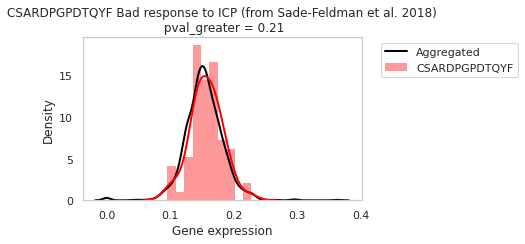

(0.15845813390175464, 0.15338014840936856, 0.005077985492386083)


/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

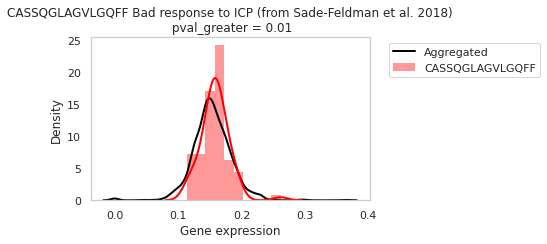

(0.16280327232323938, 0.1532892628709903, 0.00951400945224909)


/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

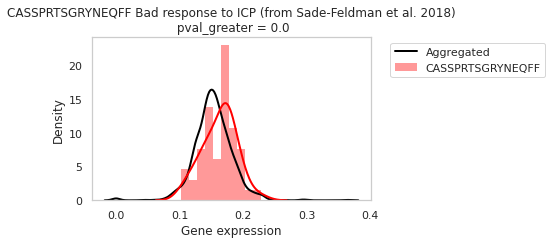

(0.16009752240907052, 0.1534286255545497, 0.006668896854520823)


/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

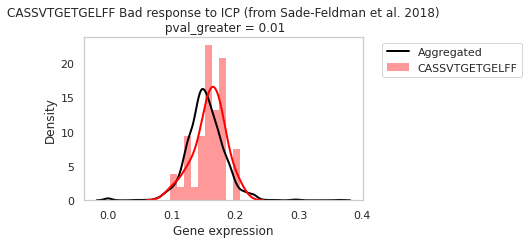

(0.1517644018051853, 0.15378913194573293, -0.0020247301405476315)


/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

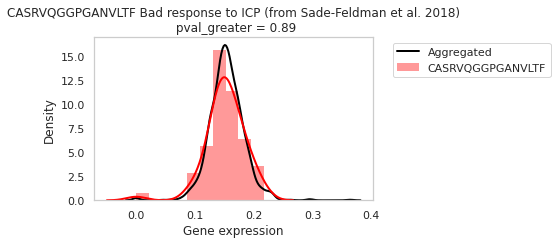

(0.15164740850505595, 0.15375299597372977, -0.002105587468673814)


/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

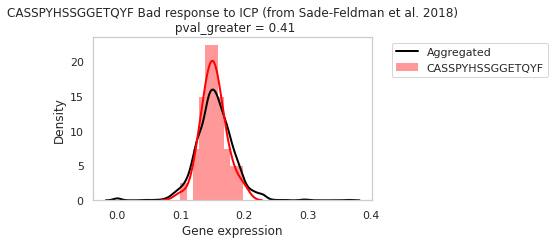

(0.14704986978690412, 0.1538859619134476, -0.006836092126543486)


/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

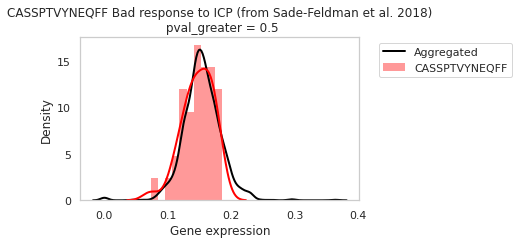

(0.15203124141635724, 0.1537343905727488, -0.0017031491563915535)


/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

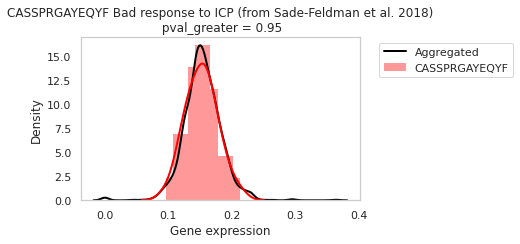

(0.15603687776593883, 0.15363815280918244, 0.0023987249567563873)


/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

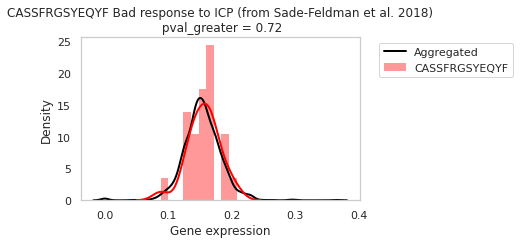

(0.14795046591323135, 0.1538199439194314, -0.005869478006200052)


/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

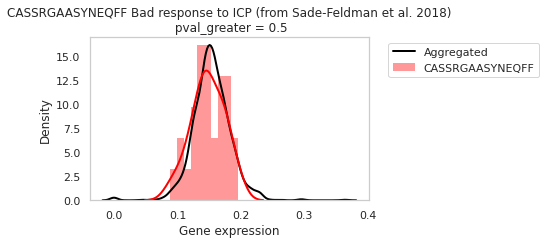

(0.15417053225809868, 0.15367820426897924, 0.0004923279891194399)


/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

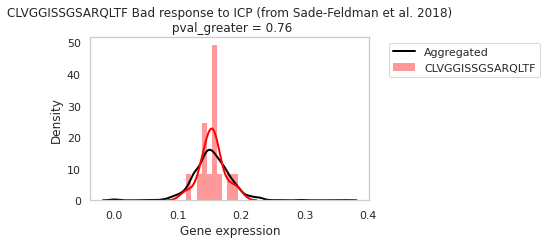

(0.16339482382364112, 0.1535584944928775, 0.009836329330763616)


/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

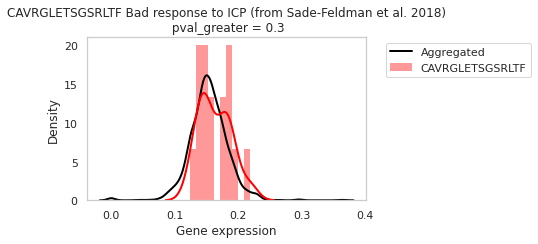

(0.1645475638814716, 0.1534989253468806, 0.01104863853459101)


/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

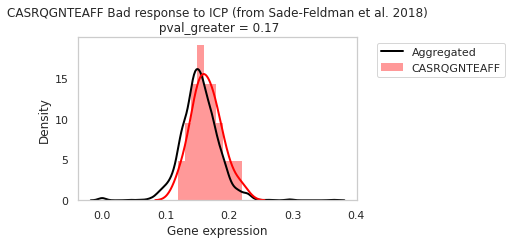

(0.15195744116782, 0.15371781633917012, -0.0017603751713501092)


/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

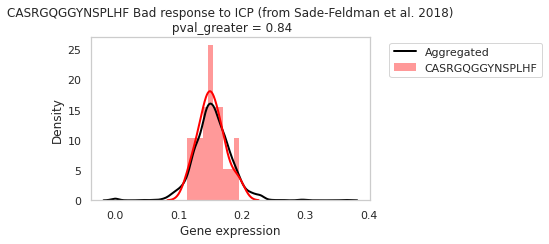

(0.1521535332174785, 0.15370264286801744, -0.001549109650538949)


/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

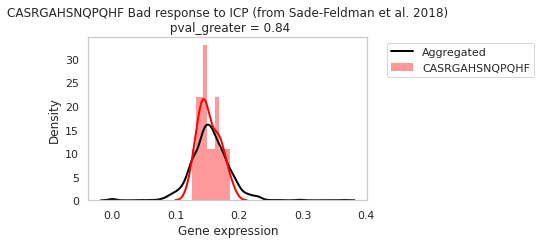

(0.15790205444751507, 0.15361220107586845, 0.0042898533716466125)


/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

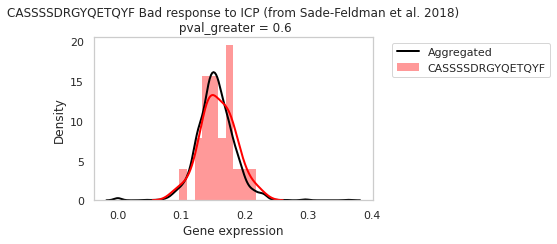

(0.14859022172269065, 0.15375415946568124, -0.005163937742990593)


/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

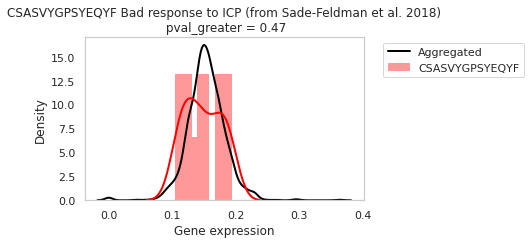

(0.16556695351017, 0.15357885537862795, 0.011988098131542058)


/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

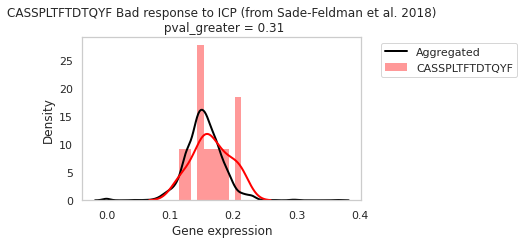

(0.16307779229679006, 0.15358561578145927, 0.009492176515330797)


/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

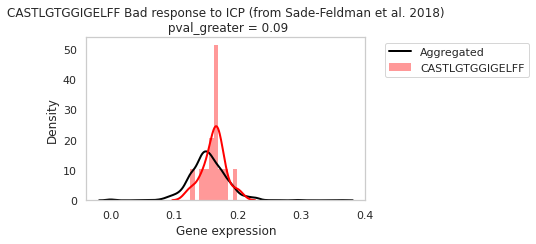

(0.15942253397965764, 0.153628609557705, 0.005793924421952645)


/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

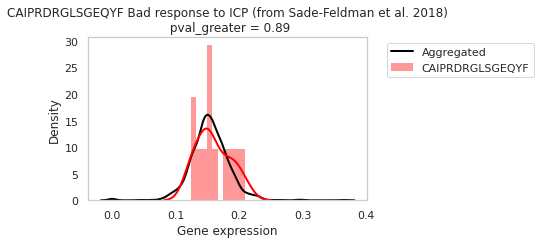

(0.16574921398477968, 0.15356743295813893, 0.012181781026640748)


/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

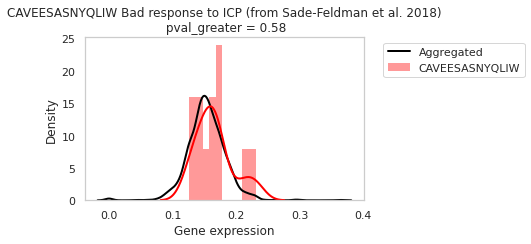

(0.15437170210539722, 0.15367744918904352, 0.0006942529163536937)


/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

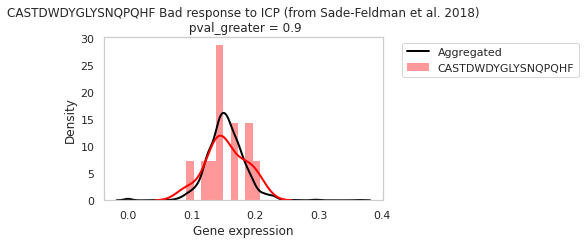

(0.1491130544065683, 0.15374322231072166, -0.004630167904153354)


/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

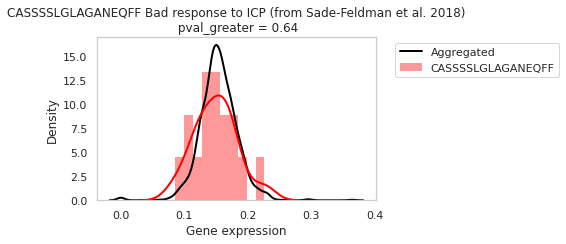

(0.1648469909016483, 0.1535214000264276, 0.011325590875220698)


/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

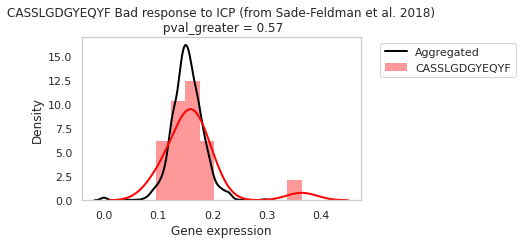

(0.156740969983261, 0.15364455889178302, 0.003096411091477985)


/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

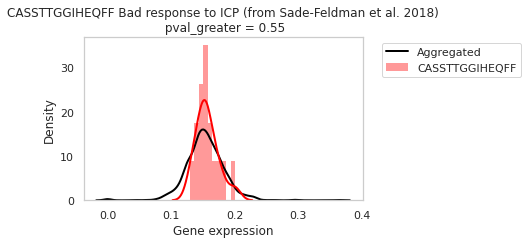

(0.14504295988254912, 0.15376062987935568, -0.008717669996806565)


/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

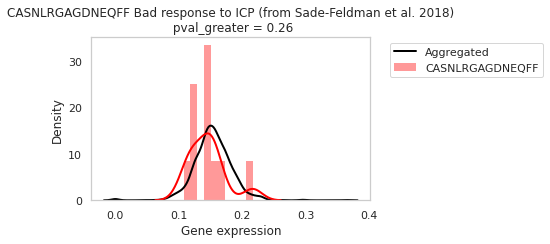

(0.14614729272966562, 0.15375697611290232, -0.007609683383236698)


/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

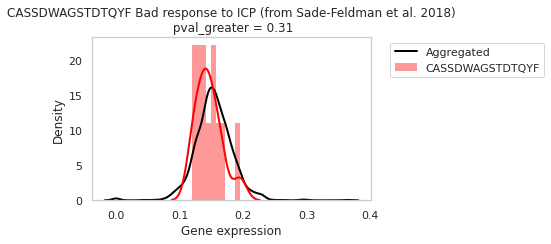

(0.15144697495228637, 0.15370391154943044, -0.0022569365971440714)


/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

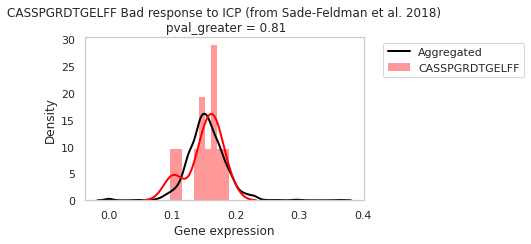

(0.1583736870155555, 0.15364637007136944, 0.004727316944186044)


/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

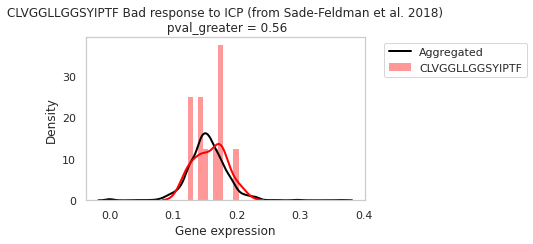

(0.15749358510002934, 0.15365345053730287, 0.0038401345627264716)


/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

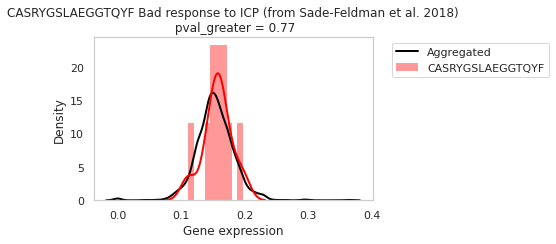

(0.15203567024634754, 0.15369869766196292, -0.0016630274156153868)


/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

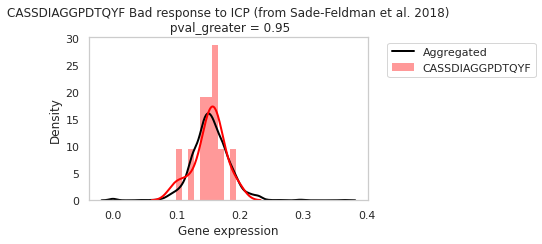

(0.15001735417647943, 0.1537135972060362, -0.0036962430295567617)


/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

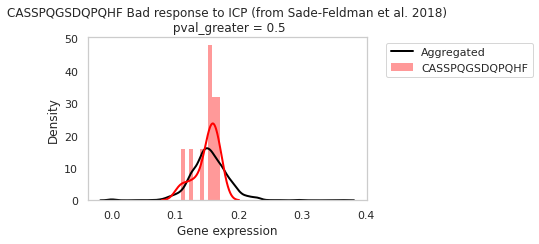

<IPython.core.display.Javascript object>

In [137]:
# Plot gene expression for each clonotype against aggregated, ks_values_all
# Looking at all beads (can try tumor only next)
# ignore beads with 0s

make_plot = True
sns.set_style("whitegrid", {"axes.grid": False})

plt.rcParams.update({"font.size": 16})
ks_values_all = {}
cls_order = []

for cl in gene_group_cl:
    agg_remove_query = []
    agg_remove_query = copy.deepcopy(gene_group_cl_agg)
    for value in gene_group_cl[cl]:
        agg_remove_query.remove(value)

    ## CHANGE THIS line for different metrics
    metric = cohens_d(gene_group_cl[cl], agg_remove_query)

    cls_order.append(cl)

    if group not in ks_values_all:
        ks_values_all[group] = [[], []]
        # Change sign depending on mean differences
    if np.mean(agg_remove_query) < np.mean(gene_group_cl[cl]):
        ks_values_all[group][0].append(metric)
    elif np.mean(agg_remove_query) > np.mean(gene_group_cl[cl]):
        ks_values_all[group][0].append(metric)

    # ks_values_all[group][1].append(kstest_greater[1])

    print(
        (
            np.mean(gene_group_cl[cl]),
            np.mean(agg_remove_query),
            np.mean(gene_group_cl[cl]) - np.mean(agg_remove_query),
        )
    )
    if make_plot:
        plt.figure(figsize=(5, 3))
        df = pd.DataFrame.from_dict(
            {
                "Gene expression": gene_group_cl[cl],
                "Clonotype": [cl] * len(gene_group_cl[cl]),
            }
        )
        df_agg = pd.DataFrame.from_dict(
            {
                "Clonotype": ["Aggregated"] * len(agg_remove_query),
                "Aggregated gene expression": agg_remove_query,
            }
        )

        sns.distplot(
            df_agg["Aggregated gene expression"],
            hist=False,
            kde=True,
            bins=int(180 / 18),
            color="black",
            hist_kws={"edgecolor": "black"},
            kde_kws={"linewidth": 2, "bw": 0.2, "alpha": 0.5},
            norm_hist=True,
            label="Aggregated",
        )

        sns.distplot(
            df["Gene expression"],
            hist=True,
            kde=True,
            bins=int(180 / 18),
            color="red",
            hist_kws={"edgecolor": "none"},
            kde_kws={"linewidth": 2, "bw": 0.5, "alpha": 0.5},
            norm_hist=True,
            label=cl,
        )

        pval_to_show = kstest(gene_group_cl[cl], agg_remove_query)[1]

        plt.title(cl + " " + group + "\n pval_greater = " + str(round(pval_to_show, 2)))
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
        plt.show()

<Figure size 720x720 with 0 Axes>

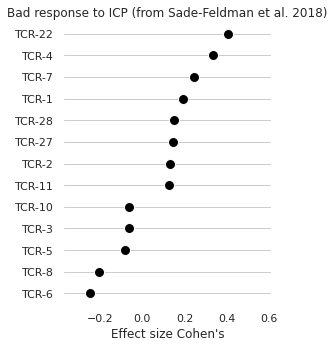

<IPython.core.display.Javascript object>

In [138]:
# Plot dot plot
group = "Bad response to ICP (from Sade-Feldman et al. 2018)"
test_dict = {i: ks_values_all[i][0] for i in ks_values_all}

test_dict["clonotype"] = cls_order

cmap_use = sns.color_palette("vlag", as_cmap=True)  # sns.diverging_palette(240, 10)

metagene_df = pd.DataFrame.from_dict(test_dict)

metagene_df.set_index(["clonotype"], inplace=True)

metagene_df = metagene_df.rename(pretty_clonotype_name)

plt.figure(figsize=(10, 10))
metagene_df.sort_values(
    "Bad response to ICP (from Sade-Feldman et al. 2018)", inplace=True
)

metagene_df["clonotype"] = list(metagene_df.index)
metagene_df.reset_index(drop=True, inplace=True)

significant_clonotypes = list(
    plot_df[plot_df.volcano_merged > -np.log10(0.05)].clonotype
)

cl_to_plot = significant_clonotypes + [
    "TCR-1",
    "TCR-2",
    "TCR-3",
]  # list(metagene_df.clonotype) #significant_clonotypes
metagene_df = metagene_df[metagene_df.clonotype.isin(cl_to_plot)]

metagene_df.clonotype = metagene_df.clonotype.astype("category")
metagene_df.clonotype.cat.set_categories(cl_to_plot, inplace=True)

metagene_df.sort_values(["clonotype"], inplace=True)

metagene_df.sort_values(group, ascending=False)
metagene_df.clonotype = metagene_df.clonotype.astype(str)
metagene_df.sort_values(group, ascending=False, inplace=True)
metagene_df_group = metagene_df[[group, "clonotype"]].copy()

g = sns.PairGrid(
    metagene_df_group,
    x_vars="Bad response to ICP (from Sade-Feldman et al. 2018)",
    y_vars=["clonotype"],
    height=5,
    aspect=0.8,
)
sns.set(font_scale=1)


g.map(
    sns.stripplot,
    size=10,
    orient="h",
    jitter=False,
    linewidth=1,
    edgecolor="w",
    color="black",
)  # palette="flare_r",
xmin = min([i for i in list(np.min(metagene_df_group)) if not isinstance(i, str)])
xmax = max([i for i in list(np.max(metagene_df_group)) if not isinstance(i, str)])
g.set(
    xlim=(xmin * 1.5, xmax * 1.5), xlabel="Effect size Cohen's", ylabel=""
)  # 0.5 for ks test and -2.5, 2.5 for t
titles = list(metagene_df_group.columns)

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

# Figure 3f

In [133]:
# Plot two distributions of gene expression based on distances split

# Calculate distances and medians
cl_distances = {}
cl_medians = {}
for cl in puck.tcr_loc_dict_s1_filtered3:
    cl_distances[cl] = [
        (pt, distance_between_points(pt, closest_node(pt, puck.boundary_points)))
        for pt in set(puck.tcr_loc_dict_s1_filtered3[cl])
        if pt in puck.tumor_beads
    ]
    cl_medians[cl] = np.median([i[1] for i in cl_distances[cl]])

gene_group_cl_below_median = {}
gene_group_cl_above_median = {}
for clonotype in tqdm(puck.tcr_loc_dict_s1_filtered3):
    if clonotype not in cl_distances:
        continue
    below_cl_locs = [
        i[0] for i in cl_distances[clonotype] if i[1] <= cl_medians[clonotype]
    ]  # if i in puck.tumor_beads
    above_cl_locs = [
        i[0] for i in cl_distances[clonotype] if i[1] > cl_medians[clonotype]
    ]
    below_bcs = [puck.loc_to_bc_s1[i] for i in below_cl_locs]
    above_bcs = [puck.loc_to_bc_s1[i] for i in above_cl_locs]
    all_cl_bcs = all_cl_bcs + cl_bcs
    if len(below_cl_locs) < 10:
        continue
    if len(above_cl_locs) < 10:
        continue
    group = "Bad response to ICP (from Sade-Feldman et al. 2018)"
    gene_group_cl_below_median[clonotype] = list(
        puck.s1_dge_fmtd_norm.loc[below_bcs, gene_groups[group]].sum(axis=1)
    )
    gene_group_cl_above_median[clonotype] = list(
        puck.s1_dge_fmtd_norm.loc[above_bcs, gene_groups[group]].sum(axis=1)
    )

/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/unix/sophliu/anaconda3/envs/tcr_env/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


  0%|          | 0/1010 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

KS CASSPRTSGRYNEQFF Bad response to ICP (from Sade-Feldman et al. 2018) 0.00023847725260117691


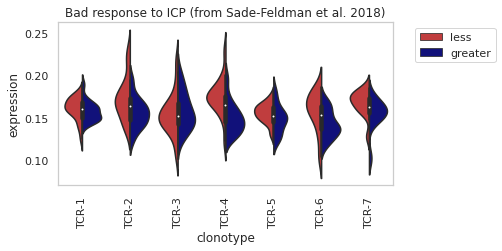

<IPython.core.display.Javascript object>

In [131]:
# Plot for each clonotype and geneset x-axis geneset expression, split by distance median.

plotting_df, pval_recorder = make_plotting_df()

plotting_df = plotting_df[plotting_df.clonotype.isin(puck.clonotypes["1b"])]

plotting_df["log_expression"] = -np.log10(plotting_df["expression"])

plt.figure(figsize=(6, 3))

cl_to_plot = list(gene_group_cl_below_median.keys())
# Heatmap merged of e
plotting_df = plotting_df[plotting_df.clonotype.isin(cl_to_plot)]
plotting_df.clonotype = plotting_df.clonotype.astype("category")
plotting_df.clonotype.cat.set_categories(cl_to_plot, inplace=True)
plotting_df.sort_values(["clonotype"], inplace=True)
plotting_df.clonotype = plotting_df.clonotype.astype(str)
plotting_df.clonotype = [
    pretty_clonotype_name[cl] for cl in list(plotting_df.clonotype)
]
plotting_df.sort_values(["clonotype"], inplace=True)
color_palette_to_use = [sns.color_palette("tab10")[3]] + ["darkblue"]
sns.violinplot(
    x="clonotype",
    y="expression",
    hue="greater_or_less",
    data=plotting_df,
    palette=color_palette_to_use,
    split=True,
    bw=0.5,
)
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.title(group)
plt.show()

In [132]:
# Multiple hypothesis correction
p_values_all_corrected = stats.multitest.multipletests(
    pval_recorder, alpha=0.05, method="fdr_bh", is_sorted=False, returnsorted=False
)
conversion_dict = dict(zip(pval_recorder, p_values_all_corrected[1]))
print(conversion_dict)

{0.05902987790590419: 0.17141589957581316, 0.35387660674356036: 0.4128560412008204, 0.00023847725260117691: 0.0016693407682082384, 0.07346395696106278: 0.17141589957581316, 0.9522562797299043: 0.9522562797299043, 0.2557751845677543: 0.358085258394856, 0.21147608841107293: 0.358085258394856}


<IPython.core.display.Javascript object>

# Figure 3g

In [118]:
# For geneset NMF analysis for heatmaps # betas, at least 10 beads in tumor
puck = puck8

all_genes = []
for group in gene_groups:
    all_genes = all_genes + gene_groups[group]
all_genes = list(set(all_genes))
all_genes_pucks = list(
    set(list(set(puck8.s1_dge_fmtd.columns) & set(puck9.s1_dge_fmtd.columns)))
    & set(puck10.s1_dge_fmtd.columns)
)
all_genes = [i for i in all_genes if i in all_genes_pucks]

tcr_bcs_in_tumor = []
for tcr in puck.tcr_loc_dict_s1_filtered3:
    if tcr not in puck.clonotypes["1b"]:
        continue
    tumor_beads_cl = {
        i
        for i in list(set(puck.tcr_loc_dict_s1_filtered3[tcr]))
        if i in puck.tumor_beads
    }
    if len(tumor_beads_cl) < 10:  # < 10: ### change to = 0 for all reps
        continue
    tcr_bcs_in_tumor = tcr_bcs_in_tumor + [puck.loc_to_bc_s1[i] for i in tumor_beads_cl]
dge = puck.s1_dge_fmtd_norm[all_genes]
dge = dge[dge.index.isin(tcr_bcs_in_tumor)]
dge["rep"] = ["p8"] * len(dge)

<IPython.core.display.Javascript object>

In [116]:
# NMF testing

N_COMPONENTS = 10
dge_values_only = dge.drop(columns=["rep"])
X = np.array(dge_values_only)
model = NMF(N_COMPONENTS, init="random", random_state=0, max_iter=1000)
model.fit_transform(X)
H = model.components_

nmf_report = {}
for factor in range(N_COMPONENTS):
    nmf_report[factor] = H[factor, :]

<IPython.core.display.Javascript object>

In [114]:
# Clonotypes passing 10 filter in tumor
puck = puck8
cl_to_plot = []
for cl in tqdm(puck.tcr_loc_dict_s1_filtered3):
    if cl not in puck.clonotypes["1b"]:
        continue
    if len(set(puck.tcr_loc_dict_s1_filtered3[cl])) < 10:
        continue
    in_tumor = [
        i for i in set(puck.tcr_loc_dict_s1_filtered3[cl]) if i in puck.tumor_beads
    ]
    if len(set(in_tumor)) < 10:
        continue
    cl_to_plot.append(cl)

nmf_df = {}

for puck in [puck8]:  ######  CHANGE THIS
    if puck == puck8:
        puck.nmf_dge = dge[dge["rep"] == "p8"]
    elif puck == puck9:
        puck.nmf_dge = dge[dge["rep"] == "p9"]
    elif puck == puck10:
        puck.nmf_dge = dge[dge["rep"] == "p10"]
    puck.nmf_dge.drop(columns=["rep"], inplace=True)

for cl in tqdm(cl_to_plot):

    for nmf_group in nmf_report:
        if nmf_group not in nmf_df:
            nmf_df[nmf_group] = []

        this_cl_dist = []
        other_cl_dist = []
        for puck in [puck8]:  ######CHANGE THIS, puck9, puck10
            if cl not in puck.tcr_loc_dict_s1_filtered3:
                continue
            bcs_for_this_cl = set(
                list(
                    [
                        puck.loc_to_bc_s1[i]
                        for i in set(puck.tcr_loc_dict_s1_filtered3[cl])
                        if i in puck.tumor_beads
                    ]
                )
            )
            puck.dge_filt = puck.nmf_dge[puck.nmf_dge.index.isin(bcs_for_this_cl)]
            this_cl_dist = this_cl_dist + [
                sum(nmf_report[nmf_group] * i) for i in np.array(puck.dge_filt)
            ]
            dge_filt_all_others = puck.nmf_dge[
                ~puck.nmf_dge.index.isin(bcs_for_this_cl)
            ]
            other_cl_dist = other_cl_dist + [
                sum(nmf_report[nmf_group] * i) for i in np.array(dge_filt_all_others)
            ]
        nmf_df[nmf_group].append(cohens_d(this_cl_dist, other_cl_dist))

  0%|          | 0/1010 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

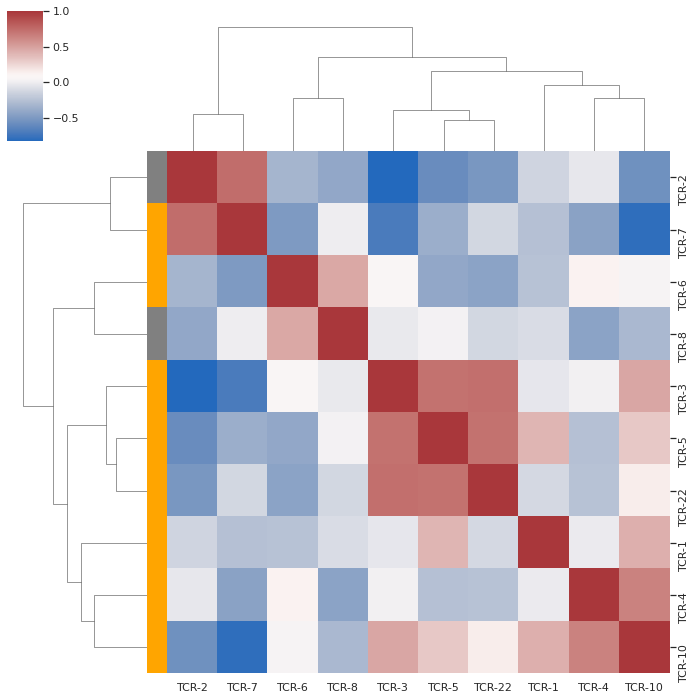

<IPython.core.display.Javascript object>

In [113]:
# Make plot
nmf_df = pd.DataFrame(nmf_df)
nmf_df.index = [pretty_clonotype_name[i] for i in cl_to_plot]

corrMatrix = nmf_df.T.corr()
significant_enriched = [
    pretty_clonotype_name[i]
    for i in cl_agg_enrichment["Tumor"]
    if cl_agg_enrichment["Tumor"][i] > 0
]
significant_depleted = [
    pretty_clonotype_name[i]
    for i in cl_agg_enrichment["Tumor"]
    if cl_agg_enrichment["Tumor"][i] < 0
]

lut = {}
for i in corrMatrix.columns:
    if i in significant_enriched:
        lut[i] = "orange"
    elif i in significant_depleted:
        lut[i] = "gray"
    else:
        lut[i] = "gray"
names = corrMatrix.index
row_colors = names.map(lut)
cmap_use = sns.color_palette("vlag", as_cmap=True)
sns.clustermap(
    corrMatrix, xticklabels=True, yticklabels=True, cmap=cmap_use, row_colors=row_colors
)
plt.show()